In [20]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,accuracy_score,
    confusion_matrix, roc_curve)
from sklearn.model_selection import learning_curve
import joblib

In [273]:
data = pd.read_csv('accepted_2007_to_2018Q4.csv', low_memory=False)
print(data.info())  # Dataset description
print(f"Total number of rows: {data.shape[0]}")  
print(data.head()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB
None
Total number of rows: 2260701
         id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     13.99       123.03     C        C4  ...                            NaN   
1     11.99       820.28     C        C1  ...                            NaN   
2     10.78       432.66     B        B4  ...                          

In [274]:
data = pd.read_csv('accepted_2007_to_2018Q4.csv', low_memory=False)

# Check the date format in the 'issue_d' column and print the first few entries
print(data['issue_d'].head(10))

# Automatically parse date format, setting invalid values as NaT
data['issue_d'] = pd.to_datetime(data['issue_d'], errors='coerce')

# Check for invalid date entries
missing_dates = data['issue_d'].isna().sum()
print(f"Found {missing_dates} invalid date entries.")

# Display examples of unrecognized date formats
invalid_dates = data[data['issue_d'].isna()]['issue_d'].unique()
print("Examples of unrecognized date formats:", invalid_dates[:10])

# Remove rows with invalid dates
data = data.dropna(subset=['issue_d'])

# Count data entries by year
data['year'] = data['issue_d'].dt.year
yearly_data_count = data['year'].value_counts().sort_index()

print("Data count per year:")
print(yearly_data_count)

# 1. Remove data from 2007 to December 2009
data = data[data['issue_d'] >= '2010-01-01']

# 2. Create the training set (2012-2016, 50,000 random samples per year)
train_data = pd.DataFrame()
for year in range(2012, 2016):
    yearly_data = data[(data['issue_d'] >= f'{year}-01-01') & (data['issue_d'] < f'{year+1}-01-01')]
    if not yearly_data.empty:
        sample_size = min(50000, len(yearly_data))  # Dynamic sampling to avoid empty sets
        sampled_data = yearly_data.sample(n=sample_size, random_state=42, replace=True)
        train_data = pd.concat([train_data, sampled_data])
        print(f"Successfully sampled {sample_size} rows for {year}.")
    else:
        print(f"Warning: No data available for {year}, skipping sampling.")

# 3. Create the testing set (2016-2018, 50,000 random samples per year)
test_data = pd.DataFrame()
for year in range(2016, 2019):
    yearly_data = data[(data['issue_d'] >= f'{year}-01-01') & (data['issue_d'] < f'{year+1}-01-01')]
    if not yearly_data.empty:
        sample_size = min(50000, len(yearly_data))  # Dynamic sampling to avoid empty sets
        sampled_data = yearly_data.sample(n=sample_size, random_state=42, replace=True)
        test_data = pd.concat([test_data, sampled_data])
        print(f"Successfully sampled {sample_size} rows for {year}.")
    else:
        print(f"Warning: No data available for {year}, skipping sampling.")

# Save datasets to files
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

print("Data processing complete. 'train_data.csv' and 'test_data.csv' files generated.")


0    Dec-2015
1    Dec-2015
2    Dec-2015
3    Dec-2015
4    Dec-2015
5    Dec-2015
6    Dec-2015
7    Dec-2015
8    Dec-2015
9    Dec-2015
Name: issue_d, dtype: object
Found 33 invalid date entries.
Examples of unrecognized date formats: <DatetimeArray>
['NaT']
Length: 1, dtype: datetime64[ns]
Data count per year:
year
2007       603
2008      2393
2009      5281
2010     12537
2011     21721
2012     53367
2013    134814
2014    235629
2015    421095
2016    434407
2017    443579
2018    495242
Name: count, dtype: int64
Successfully sampled 50000 rows for 2012.
Successfully sampled 50000 rows for 2013.
Successfully sampled 50000 rows for 2014.
Successfully sampled 50000 rows for 2015.
Successfully sampled 50000 rows for 2016.
Successfully sampled 50000 rows for 2017.
Successfully sampled 50000 rows for 2018.
Data processing complete. 'train_data.csv' and 'test_data.csv' files generated.


In [275]:


# Load training and testing datasets
train_data = pd.read_csv('train_data.csv', low_memory=False)
test_data = pd.read_csv('test_data.csv', low_memory=False)

# Total feature count before cleaning
original_feature_count = train_data.shape[1]
print(f"Feature count before cleaning: {original_feature_count}")

# Calculate the percentage of missing values for each feature
missing_percentage = train_data.isnull().mean() * 100

# Save the distribution of missing values to a CSV file
missing_data = pd.DataFrame({
    'Feature': missing_percentage.index,
    'Missing Percentage (%)': missing_percentage.values
}).sort_values(by='Missing Percentage (%)', ascending=False)

print("Missing value distribution saved to 'missing_values.csv'")
missing_data.to_csv('missing_values.csv', index=False)

# Select columns with more than 10% missing values
columns_to_drop = missing_percentage[missing_percentage > 10].index

# Apply column removal to both training and testing datasets
train_data_cleaned = train_data.drop(columns=columns_to_drop)
test_data_cleaned = test_data.drop(columns=columns_to_drop)

# Feature count after cleaning
cleaned_feature_count = train_data_cleaned.shape[1]
print(f"Feature count after cleaning: {cleaned_feature_count}")
print(f"Number of features removed: {original_feature_count - cleaned_feature_count}")

# Save the cleaned datasets
train_data_cleaned.to_csv('cleaned_train_data.csv', index=False)
test_data_cleaned.to_csv('cleaned_test_data.csv', index=False)

print("Cleaned data saved as 'cleaned_train_data.csv' and 'cleaned_test_data.csv'")


Feature count before cleaning: 152
Missing value distribution saved to 'missing_values.csv'
Feature count after cleaning: 70
Number of features removed: 82
Cleaned data saved as 'cleaned_train_data.csv' and 'cleaned_test_data.csv'


In [276]:


# Load datasets
train_data = pd.read_csv('cleaned_train_data.csv', low_memory=False)
test_data = pd.read_csv('cleaned_test_data.csv', low_memory=False)

# Print the initial feature count
print(f"Initial feature count in training set: {train_data.shape[1]}")
print(f"Initial feature count in testing set: {test_data.shape[1]}")

# Step 4: Drop irrelevant columns
columns_to_drop = [
    'sub_grade',           # Duplicated with 'grade'
    'application_type',    # All values are 'individual'
    'zip_code',            # Only 'addr_state' is needed, zip code is not meaningful
    'url',                 # URL has no predictive value
    'title',
    'emp_title'            # Too many unique values, not useful for analysis
]

train_data_cleaned = train_data.drop(columns=columns_to_drop)
test_data_cleaned = test_data.drop(columns=columns_to_drop)

# Step 5: Transform specific columns
# 1. 'term' column: Convert '36 months' to 36, '60 months' to 60
def convert_term(term):
    if isinstance(term, str):
        return int(term.strip().replace(' months', ''))
    return term

train_data_cleaned['term'] = train_data_cleaned['term'].apply(convert_term)
test_data_cleaned['term'] = test_data_cleaned['term'].apply(convert_term)

# 2. 'emp_length' column: Handle various formats and convert to numeric
def convert_emp_length(emp_length):
    if pd.isnull(emp_length):
        return None
    if isinstance(emp_length, float):
        return emp_length
    emp_length = emp_length.strip().lower()
    
    if emp_length == '< 1 year':
        return 0
    elif emp_length == '10+ years':
        return 10
    elif 'year' in emp_length:
        return int(emp_length.replace(' years', '').replace(' year', ''))
    else:
        return None

train_data_cleaned['emp_length'] = train_data_cleaned['emp_length'].apply(convert_emp_length)
test_data_cleaned['emp_length'] = test_data_cleaned['emp_length'].apply(convert_emp_length)

print("Conversion of 'term' and 'emp_length' columns completed")

# Step 6: Encode specified columns as numerical values
columns_to_encode = ['grade', 'verification_status', 'home_ownership', 'purpose', 
                     'initial_list_status', 'pymnt_plan', 'hardship_flag', 
                     'debt_settlement_flag', 'disbursement_method']

for column in columns_to_encode:
    unique_values = train_data_cleaned[column].unique()
    value_mapping = {value: idx + 1 for idx, value in enumerate(unique_values)}
    print(f"Encoding mapping for column '{column}': {value_mapping}")
    
    train_data_cleaned[column] = train_data_cleaned[column].map(value_mapping)
    test_data_cleaned[column] = test_data_cleaned[column].map(value_mapping)

# Special handling for the target variable 'loan_status'
def map_loan_status(status):
    # Default status -> 1 (Default)
    if status in ['Charged Off', 'In Grace Period', 'Late (31–120 days)', 'Late (16–30 days)']:
        return 1
    # Non-default status -> 0
    elif status in ['Fully Paid', 'Current']:
        return 0
    # Other rare cases are treated as 0 (Non-default)
    else:
        return 0

# Apply the mapping rule to the 'loan_status' column
train_data_cleaned['loan_status'] = train_data_cleaned['loan_status'].apply(map_loan_status)
test_data_cleaned['loan_status'] = test_data_cleaned['loan_status'].apply(map_loan_status)

# Verify the mapping result
print(train_data_cleaned['loan_status'].value_counts())
print(test_data_cleaned['loan_status'].value_counts())

# Ensure train and test datasets have aligned columns
missing_cols = set(train_data_cleaned.columns) - set(test_data_cleaned.columns)
for col in missing_cols:
    test_data_cleaned[col] = 0

extra_cols = set(test_data_cleaned.columns) - set(train_data_cleaned.columns)
test_data_cleaned = test_data_cleaned.drop(columns=extra_cols)

test_data_cleaned = test_data_cleaned[train_data_cleaned.columns]

print("Ensured train and test datasets have matching columns")

# Print the feature count after cleaning
print(f"Feature count after cleaning (train set): {train_data_cleaned.shape[1]}")
print(f"Feature count after cleaning (test set): {test_data_cleaned.shape[1]}")

# Save the encoded datasets
train_data_cleaned.to_csv('cleaned_train_data_step6.csv', index=False)
test_data_cleaned.to_csv('cleaned_test_data_step6.csv', index=False)

print("Encoded data saved as 'cleaned_train_data_step6.csv' and 'cleaned_test_data_step6.csv'")


Initial feature count in training set: 70
Initial feature count in testing set: 70
Conversion of 'term' and 'emp_length' columns completed
Encoding mapping for column 'grade': {'A': 1, 'C': 2, 'B': 3, 'E': 4, 'D': 5, 'F': 6, 'G': 7}
Encoding mapping for column 'verification_status': {'Verified': 1, 'Source Verified': 2, 'Not Verified': 3}
Encoding mapping for column 'home_ownership': {'MORTGAGE': 1, 'OWN': 2, 'RENT': 3, 'NONE': 4, 'OTHER': 5}
Encoding mapping for column 'purpose': {'home_improvement': 1, 'debt_consolidation': 2, 'other': 3, 'major_purchase': 4, 'wedding': 5, 'house': 6, 'small_business': 7, 'credit_card': 8, 'medical': 9, 'car': 10, 'moving': 11, 'vacation': 12, 'renewable_energy': 13}
Encoding mapping for column 'initial_list_status': {'f': 1, 'w': 2}
Encoding mapping for column 'pymnt_plan': {'n': 1, 'y': 2}
Encoding mapping for column 'hardship_flag': {'N': 1, 'Y': 2}
Encoding mapping for column 'debt_settlement_flag': {'N': 1, 'Y': 2}
Encoding mapping for column 'd

In [277]:
# Load cleaned datasets
train_data = pd.read_csv('cleaned_train_data_step6.csv', low_memory=False)
test_data = pd.read_csv('cleaned_test_data_step6.csv', low_memory=False)

# Record the initial sample counts
initial_train_samples = train_data.shape[0]
initial_test_samples = test_data.shape[0]

# Calculate the percentage of missing values in the training set
missing_values_train = train_data.isnull().sum()
missing_percentage_train = (missing_values_train / len(train_data)) * 100
print("Missing values in the training set:")
print(missing_percentage_train[missing_percentage_train > 0].sort_values(ascending=False))

# Calculate the percentage of missing values in the testing set
missing_values_test = test_data.isnull().sum()
missing_percentage_test = (missing_values_test / len(test_data)) * 100
print("\nMissing values in the testing set:")
print(missing_percentage_test[missing_percentage_test > 0].sort_values(ascending=False))

# Remove rows with missing values
train_data_cleaned = train_data.dropna()
test_data_cleaned = test_data.dropna()

# Record the final sample counts
final_train_samples = train_data_cleaned.shape[0]
final_test_samples = test_data_cleaned.shape[0]

print(f"\nTraining set samples: Before = {initial_train_samples}, After = {final_train_samples}")
print(f"Testing set samples: Before = {initial_test_samples}, After = {final_test_samples}")

# Save the cleaned datasets
train_data_cleaned.to_csv('cleaned_train_data_no_missing_rows.csv', index=False)
test_data_cleaned.to_csv('cleaned_test_data_no_missing_rows.csv', index=False)

print("\nCleaned data saved as 'cleaned_train_data_no_missing_rows.csv' and 'cleaned_test_data_no_missing_rows.csv'")



Missing values in the training set:
num_bc_sats             7.4225
num_sats                7.4225
emp_length              4.7095
bc_util                 4.5225
percent_bc_gt_75        4.4830
bc_open_to_buy          4.4565
mths_since_recent_bc    4.3800
acc_open_past_24mths    3.5110
mort_acc                3.5110
total_bal_ex_mort       3.5110
total_bc_limit          3.5110
last_pymnt_d            0.0790
revol_util              0.0700
last_credit_pull_d      0.0065
dtype: float64

Missing values in the testing set:
emp_length              7.387333
disbursement_method     5.364667
bc_util                 1.264667
percent_bc_gt_75        1.219333
bc_open_to_buy          1.218667
mths_since_recent_bc    1.138000
last_pymnt_d            0.133333
dti                     0.123333
revol_util              0.090667
home_ownership          0.058667
purpose                 0.001333
last_credit_pull_d      0.000667
dtype: float64

Training set samples: Before = 200000, After = 174279
Testing set s

In [278]:
# **Step 1: Load the original dataset**
train_data_backup = pd.read_csv('cleaned_train_data_no_missing_rows.csv', low_memory=False)
test_data_backup = pd.read_csv('cleaned_test_data_no_missing_rows.csv', low_memory=False)

# Backup ID column
train_ids = train_data_backup['id']
test_ids = test_data_backup['id']

# **Step 2: Remove time and location-related columns**
columns_to_exclude = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d', 'addr_state']
train_data = train_data_backup.drop(columns=columns_to_exclude, errors='ignore')
test_data = test_data_backup.drop(columns=columns_to_exclude, errors='ignore')

print(f"Initial feature count: {train_data.shape[1]}")

# **Step 3: Handle NaN values to prevent issues during standardization**
train_data.fillna(0, inplace=True)
test_data.fillna(0, inplace=True)

# **Step 4: Standardize the data**
scaler = StandardScaler()
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data_scaled = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

# **Step 5: Low variance feature filtering**
variance_threshold = 0.01
var_selector = VarianceThreshold(threshold=variance_threshold)
var_selector.fit(train_data_scaled)

low_variance_features = train_data_scaled.columns[var_selector.get_support()]
train_data_scaled = train_data_scaled[low_variance_features]
test_data_scaled = test_data_scaled[low_variance_features]

print(f"Remaining features after variance filtering: {train_data_scaled.shape[1]}")

# **Step 6: High correlation feature filtering**
correlation_threshold = 0.9
corr_matrix = train_data_scaled.corr().abs()

high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > correlation_threshold:
            high_corr_features.add(corr_matrix.columns[i])

print(f"High correlation features (> {correlation_threshold}) to be removed: {len(high_corr_features)}")

train_data_scaled = train_data_scaled.drop(columns=high_corr_features, errors='ignore')
test_data_scaled = test_data_scaled.drop(columns=high_corr_features, errors='ignore')

print(f"Remaining features after correlation filtering: {train_data_scaled.shape[1]}")

# **Step 7: Coefficient of Variation (CV) filtering**
cv_threshold = 0.1
cv_values = train_data_scaled.std() / train_data_scaled.mean().replace(0, 1e-8)  # Avoid division by zero
low_cv_features = cv_values[cv_values < cv_threshold].index.tolist()

print(f"Low CV features (CV < {cv_threshold}) to be removed: {len(low_cv_features)}")

train_data_scaled = train_data_scaled.drop(columns=low_cv_features, errors='ignore')
test_data_scaled = test_data_scaled.drop(columns=low_cv_features, errors='ignore')

print(f"Remaining features after CV filtering: {train_data_scaled.shape[1]}")


Initial feature count: 59
Remaining features after variance filtering: 57
High correlation features (> 0.9) to be removed: 10
Remaining features after correlation filtering: 47
Low CV features (CV < 0.1) to be removed: 28
Remaining features after CV filtering: 19


### During the automatic feature selection process, some features may have been excluded due to low variance or high correlation, but they are very important from a business perspective, including:

annual_inc (Annual Income):
Business Importance: Directly impacts the borrower's repayment ability and should be manually included as a feature.

dti (Debt-to-Income Ratio):
Business Importance: A critical indicator of the borrower's financial stress. A high DTI often indicates an increased risk of default.

fico_range (FICO Credit Score):
Business Importance: The existing features include last_fico_range_high and last_fico_range_low, but it is better to include the initial FICO score as well to observe the trend of credit score changes.

employment_length (Employment Length):
Business Importance: Job stability can be a reference for financial stability, especially during economic fluctuations.

installment (Monthly Payment Amount):
Business Importance: Combined with income, it can calculate the monthly repayment pressure, helping the model understand the borrower's cash flow stress.

revol_util (Credit Card Utilization Rate):
Business Importance: Reflects the borrower's credit card debt ratio. High utilization may indicate financial difficulties.

hardship_flag (Hardship Status):
Business Importance: If the borrower has applied for a hardship assistance plan, it may indicate a high risk of default.

In [280]:
# **Step 8: Manually add business-critical features**
manual_features = ['annual_inc', 'dti', 'fico_range_low', 'fico_range_high', 'emp_length',
                   'installment', 'revol_util', 'hardship_flag', 
                   'last_fico_range_high', 'last_fico_range_low', 'addr_state','loan_status']

# **Additional processing for issue_d**
if 'issue_d' in train_data_backup.columns:
    train_data_backup['issue_d'] = pd.to_datetime(train_data_backup['issue_d'], errors='coerce')
    test_data_backup['issue_d'] = pd.to_datetime(test_data_backup['issue_d'], errors='coerce')

    # Create two numerical features: year and month
    train_data_backup['issue_year'] = train_data_backup['issue_d'].dt.year
    train_data_backup['issue_month'] = train_data_backup['issue_d'].dt.month
    test_data_backup['issue_year'] = test_data_backup['issue_d'].dt.year
    test_data_backup['issue_month'] = test_data_backup['issue_d'].dt.month

    print("Converted issue_d to numerical features: 'issue_year' and 'issue_month'.")

    # Add the numeric issue_d features to the manual feature list
    manual_features.extend(['issue_year', 'issue_month'])

# **Add manually selected features**
for feature in manual_features:
    if feature in train_data_backup.columns and feature not in train_data_scaled.columns:
        train_data_scaled[feature] = train_data_backup[feature]
        test_data_scaled[feature] = test_data_backup[feature]
        print(f"Manually added feature: {feature}")

print(f"Feature count after manual addition: {train_data_scaled.shape[1]}")



print("Manually added features have been standardized.")

# **Step 9: Process addr_state**
if 'addr_state' in train_data_scaled.columns:
    addr_state_map = {state: idx for idx, state in enumerate(train_data_backup['addr_state'].unique())}
    
    # Map addr_state to numerical values
    train_data_scaled['addr_state'] = train_data_backup['addr_state'].map(addr_state_map)
    test_data_scaled['addr_state'] = test_data_backup['addr_state'].map(addr_state_map)

    print("Mapped addr_state to unique integer values:", addr_state_map)

# **Standardize manually added features**
scaler_manual = StandardScaler()
train_data_scaled[manual_features] = scaler_manual.fit_transform(train_data_scaled[manual_features])
test_data_scaled[manual_features] = scaler_manual.transform(test_data_scaled[manual_features])

# **Step 10: Reinsert the 'id' column**
train_data_scaled.insert(0, 'id', train_ids)
test_data_scaled.insert(0, 'id', test_ids)

# **Step 11: Retain only the features from `selected_features` that exist**
selected_features = [
    'loan_amnt', 'term', 'grade', 'home_ownership', 'pymnt_plan', 'purpose', 
    'inq_last_6mths', 'pub_rec', 'revol_bal', 'total_acc', 'initial_list_status', 
    'recoveries', 'last_fico_range_high', 'last_fico_range_low', 'acc_now_delinq', 
    'acc_open_past_24mths', 'chargeoff_within_12_mths', 'num_bc_sats', 
    'debt_settlement_flag', 'annual_inc', 'dti', 'fico_range_low', 'fico_range_high', 
    'emp_length', 'installment', 'revol_util', 'hardship_flag', 'id', 'addr_state', 
    'issue_year','loan_status'  # issue_d is no longer used, instead, its numerical version is retained
]

# Retain only the existing features
available_features = [col for col in selected_features if col in train_data_scaled.columns]
train_data_scaled = train_data_scaled[available_features]
test_data_scaled = test_data_scaled[available_features]

# **Step 12: Ensure 'id' is the first column**
train_data_scaled = train_data_scaled[['id'] + [col for col in available_features if col != 'id']]
test_data_scaled = test_data_scaled[['id'] + [col for col in available_features if col != 'id']]

# **Step 13: Output the final retained feature list**
print("Final retained features:", train_data_scaled.columns.tolist())
print(f"Final feature count (including 'id'): {train_data_scaled.shape[1]}")

# **Step 14: Save the final standardized datasets**
train_data_scaled.to_csv('final_train_data.csv', index=False)
test_data_scaled.to_csv('final_test_data.csv', index=False)

print("\nFinal datasets saved as 'final_train_data.csv' and 'final_test_data.csv'")

# **Step 15: Save the unstandardized original dataset**
# Retain only `available_features` (the unstandardized dataset retains the original issue_d)
train_data_unscaled = train_data_backup[available_features]
test_data_unscaled = test_data_backup[available_features]

# **Ensure column order matches `train_data_scaled`**
train_data_unscaled = train_data_unscaled[train_data_scaled.columns.tolist()]
test_data_unscaled = test_data_unscaled[test_data_scaled.columns.tolist()]

# **Save the unstandardized dataset**
train_data_unscaled.to_csv('final_train_data_without_standardization.csv', index=False)
test_data_unscaled.to_csv('final_test_data_without_standardization.csv', index=False)

print("\nUnstandardized datasets saved with matching columns as 'final_train_data_without_standardization.csv' and 'final_test_data_without_standardization.csv'")


Converted issue_d to numerical features: 'issue_year' and 'issue_month'.
Manually added feature: annual_inc
Manually added feature: dti
Manually added feature: fico_range_low
Manually added feature: fico_range_high
Manually added feature: emp_length
Manually added feature: installment
Manually added feature: revol_util
Manually added feature: hardship_flag
Manually added feature: addr_state
Manually added feature: loan_status
Manually added feature: issue_year
Manually added feature: issue_month
Feature count after manual addition: 31
Manually added features have been standardized.
Mapped addr_state to unique integer values: {'CA': 0, 'FL': 1, 'NJ': 2, 'GA': 3, 'OR': 4, 'NC': 5, 'MI': 6, 'AR': 7, 'MD': 8, 'MA': 9, 'TX': 10, 'AZ': 11, 'OK': 12, 'NY': 13, 'MN': 14, 'OH': 15, 'LA': 16, 'AK': 17, 'PA': 18, 'KS': 19, 'VA': 20, 'AL': 21, 'HI': 22, 'IL': 23, 'WA': 24, 'MO': 25, 'WI': 26, 'CO': 27, 'NM': 28, 'SC': 29, 'CT': 30, 'MT': 31, 'NH': 32, 'NV': 33, 'DE': 34, 'KY': 35, 'WY': 36, 'RI': 

## Combine datasets with macroeconomic data

In [282]:
# import data into a pandas dataframe
df = pd.read_csv("Final_v1.csv", encoding="utf-8", sep=',')
test_df = pd.read_csv("Final_test_v2.csv", encoding="utf-8", sep=',')

print(df)
print(test_df)
# map the state names to codes
state_code_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas',
    'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
    'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
    'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah',
    'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia',
    'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'District of Columbia'
}

              id  loan_amnt  term  grade  home_ownership  pymnt_plan  purpose  \
0        1590374    35000.0    36      1               1           1        1   
1        2477367     4925.0    36      2               2           1        2   
2        1690344    31200.0    60      4               1           1        2   
3        2214910     5400.0    36      3               3           1        2   
4        1578408    17500.0    60      5               3           1        2   
...          ...        ...   ...    ...             ...         ...      ...   
174274  41760700     5000.0    36      5               3           1        3   
174275  40715544    16000.0    36      2               1           1        2   
174276  66590706    12000.0    60      3               3           1        2   
174277  52280403    24000.0    36      1               1           1        8   
174278  68514852    21000.0    36      3               1           1        2   

        inq_last_6mths  pub

In [283]:
def merge_macroecon_data(df_base, macro_path, new_col_name, skiprows=3):
    """
    Merges a macroeconomic indicator into df_base based on state and year.
    
    Parameters:
    - df_base: main DataFrame (e.g., Final_v1.csv loaded as DataFrame)
    - macro_path: path to macroeconomic CSV file
    - new_col_name: name to assign to the merged indicator column
    - skiprows: number of rows to skip at the start of the macro file (default=3)
    
    Returns:
    - merged DataFrame with the new column
    """
    try:
        # 尝试跳过说明性文字并读取数据
        df_macro = pd.read_csv(macro_path, skiprows=skiprows)

        # 检查是否包含所需列
        if "GeoName" not in df_macro.columns:
            raise ValueError(f"'GeoName' column not found in {macro_path}")

        # 提取年份列
        year_cols = [col for col in df_macro.columns if col.isdigit()]
        if not year_cols:
            raise ValueError(f"No year columns found in {macro_path}")

        # 将数据从宽格式转换为长格式
        df_macro_melted = df_macro.melt(
            id_vars=["GeoName"],
            value_vars=year_cols,
            var_name="issue_year",
            value_name=new_col_name
        )
        df_macro_melted["issue_year"] = df_macro_melted["issue_year"].astype(int)

        # 映射州名
        df_base = df_base.copy()
        df_base["state_name"] = df_base["addr_state"].map(state_code_to_name)

        # 合并数据
        merged = df_base.merge(
            df_macro_melted,
            how="left",
            left_on=["state_name", "issue_year"],
            right_on=["GeoName", "issue_year"]
        )

        return merged.drop(columns=["state_name", "GeoName"])
    
    except Exception as e:
        print(f" Failed to process file {macro_path}: {e}")
        return df_base


In [284]:
# merge macroecon data


# Apply the function
files = ["Macroecon_data/%Implicit regional price deflator.csv",
         "Macroecon_data/%State Per capital personal consumption expenditures(PCE).csv",
         "Macroecon_data/%State Total employment growth.csv",
         "Macroecon_data/Regional price parities (RPPs) all items.csv",
         "Macroecon_data/State GDP Growth % Summary .csv",
         "Macroecon_data/State Real per capita personal income.csv"]

# 最初のDataFrameを用意（Final_v1.csvなど）
final_df = df.copy()

# すべてのマクロ経済データをマージ
for file_path in files:
    # ファイル名からカラム名を自動生成（拡張子除去・記号除去・小文字化）
    base = os.path.basename(file_path).replace(".csv", "")
    col_name = base.replace("%", "").replace("(", "").replace(")", "").replace(" ", "_").lower()
    
    final_df = merge_macroecon_data(final_df, file_path, new_col_name=col_name)

# print result
final_df.head()

# mearge interest rate
interest_rate_df = pd.read_csv("Macroecon_data/fed_interest_rate_2012_2019.csv")

final_df = final_df.merge(interest_rate_df, how="left",
                              left_on=["issue_year"],
                              right_on=["year"])

final_df = final_df.drop(columns=["year"])
final_df

unemp_df = pd.read_csv("Macroecon_data/%state_unemployment_2012_2019.csv")

# Extract year columns (must be digits)
year_cols = [col for col in unemp_df.columns if col.isdigit()]
unemp_df_melted = unemp_df.melt(id_vars=["state"], value_vars=year_cols,
                                    var_name="issue_year", value_name="unemployment_rate")
unemp_df_melted["issue_year"] = unemp_df_melted["issue_year"].astype(int)

#df_base["state_name"] = df_base["addr_state"].map(state_code_to_name)

final_df = final_df.merge(unemp_df_melted, how="left",
                           left_on=["addr_state", "issue_year"],
                           right_on=["state", "issue_year"])

final_df = final_df.drop(columns=["state"])
final_df
# export to csv
final_df.to_csv("Final_v2.csv", index=False)
print("Final_v2.csv has been completed sucessfully")
# create a df for processed data
df_processed = final_df.copy()
test_df_processed = test_df.copy()

Final_v2.csv has been completed sucessfully


# 测试事后变量对于预测的提升

Final_with_leak_feature.csv

===== loan_status Distribution =====
loan_status
0    0.834134
1    0.165866
Name: proportion, dtype: float64

Using class_weight='balanced': True

Fold 1 | AUC: 0.9915 | F1: 0.9290 | Precision: 0.9845 | Recall: 0.8794 | Accuracy: 0.9777

Fold 2 | AUC: 0.9910 | F1: 0.9242 | Precision: 0.9830 | Recall: 0.8720 | Accuracy: 0.9763

Fold 3 | AUC: 0.9922 | F1: 0.9297 | Precision: 0.9830 | Recall: 0.8819 | Accuracy: 0.9779

Fold 4 | AUC: 0.9901 | F1: 0.9244 | Precision: 0.9846 | Recall: 0.8712 | Accuracy: 0.9764

Fold 5 | AUC: 0.9908 | F1: 0.9322 | Precision: 0.9846 | Recall: 0.8851 | Accuracy: 0.9787

===== Cross-Validation Metrics (5-Fold) =====
Mean AUC       : 0.9911
Mean Accuracy  : 0.9774
Mean F1 Score  : 0.9279
Mean Precision : 0.9839
Mean Recall    : 0.8779


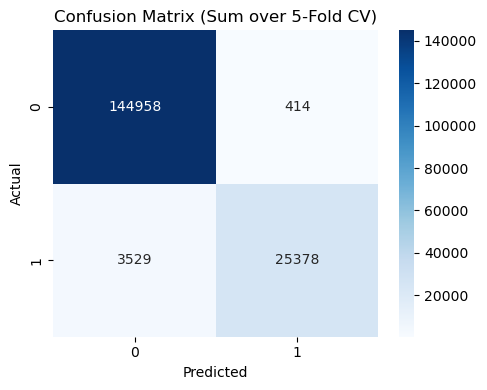

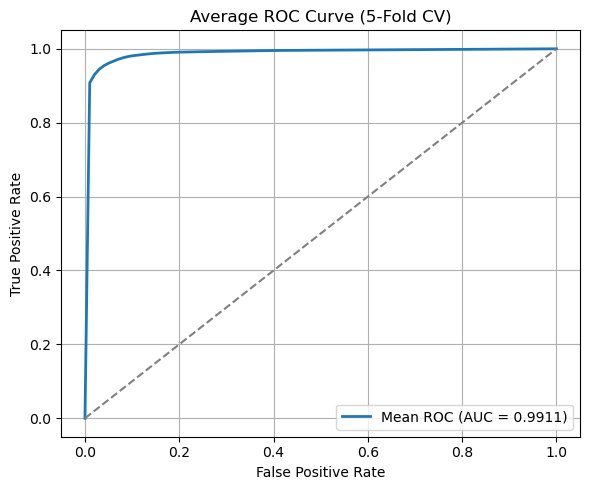

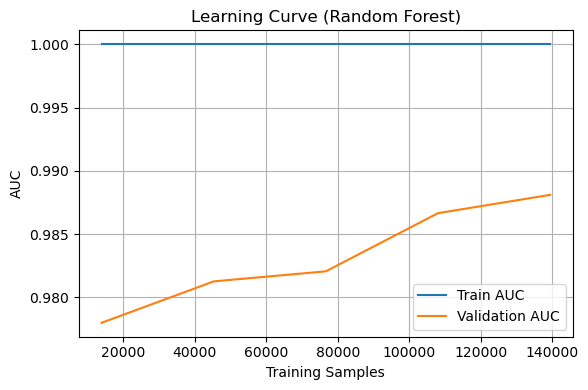

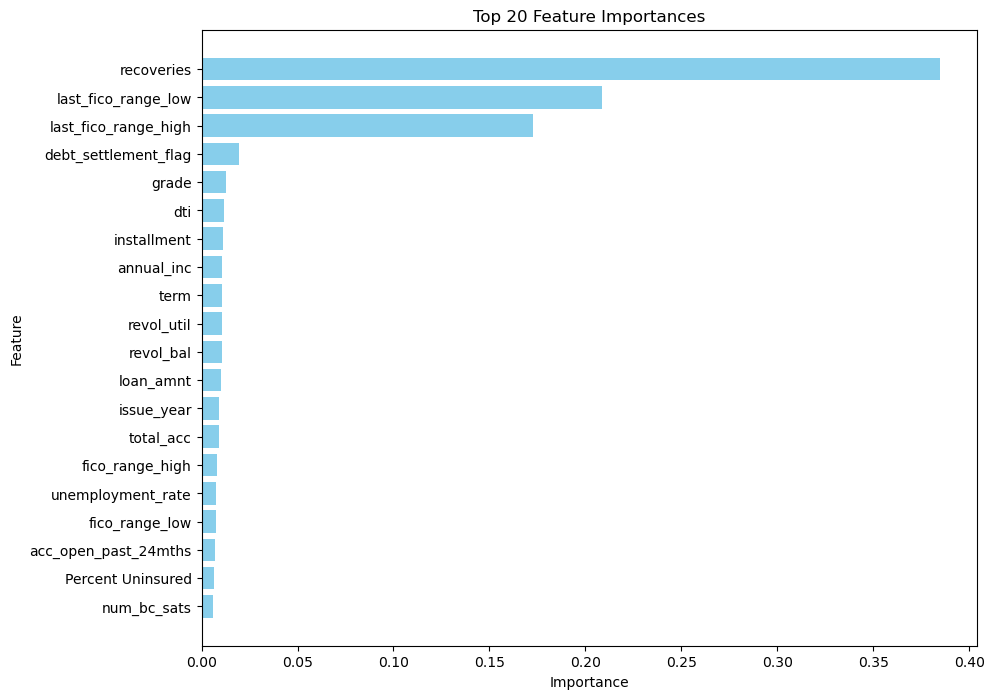

In [506]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# === 读取原始数据 ===
final_df = pd.read_csv("Final_v2.csv")
test_df = pd.read_csv("Final_test_v2.csv")

# === 删除无用列 ===
drop_cols = ["id"]
final_df = final_df.drop(columns=drop_cols, errors='ignore')
test_df = test_df.drop(columns=drop_cols, errors='ignore')

# === Label encode addr_state ===
le = LabelEncoder()
final_df['addr_state'] = le.fit_transform(final_df['addr_state'])
test_df['addr_state'] = le.transform(test_df['addr_state'])

# === 分离待保留列 ===
final_label = final_df[['loan_status', 'addr_state']]
test_label = test_df[['loan_status', 'addr_state']]

final_features = final_df.drop(columns=['loan_status', 'addr_state'])
test_features = test_df.drop(columns=['loan_status', 'addr_state'])

# === 标准化数值特征 ===
scaler = StandardScaler()
final_scaled = pd.DataFrame(scaler.fit_transform(final_features), columns=final_features.columns)
test_scaled = pd.DataFrame(scaler.transform(test_features), columns=test_features.columns)

# === 合并回保留列 ===
final_processed = pd.concat([final_scaled, final_label.reset_index(drop=True)], axis=1)
test_processed = pd.concat([test_scaled, test_label.reset_index(drop=True)], axis=1)

# === 保存处理后数据 ===
final_processed.to_csv("Final_with_leak_feature.csv", index=False)

print("Final_with_leak_feature.csv")
train_df = pd.read_csv("Final_with_leak_feature.csv")

# 检查目标变量是否平衡
class_counts = train_df['loan_status'].value_counts(normalize=True)
print("\n===== loan_status Distribution =====")
print(class_counts)

# 判断是否需要 class_weight
use_class_weight = class_counts.min() < 0.4
print(f"\nUsing class_weight='balanced': {use_class_weight}")

# 拆分特征与目标变量（排除 id）
X = train_df.drop(columns=['loan_status'])
y = train_df['loan_status']

# 初始化模型
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced' if use_class_weight else None
)

# 初始化交叉验证器
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 存储评估指标
auc_scores, f1_scores, precision_scores, recall_scores, accuracy_scores = [], [], [], [], []
conf_matrix_sum = np.zeros((2, 2), dtype=int)
mean_fpr = np.linspace(0, 1, 100)
tprs = []

# 执行交叉验证
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    y_prob = rf.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_prob)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)

    auc_scores.append(auc)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    accuracy_scores.append(accuracy)
    conf_matrix_sum += cm

    fpr, tpr, _ = roc_curve(y_val, y_prob)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

    print(f"\nFold {fold} | AUC: {auc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | Accuracy: {accuracy:.4f}")


# 汇总评估指标
print("\n===== Cross-Validation Metrics (5-Fold) =====")
print(f"Mean AUC       : {np.mean(auc_scores):.4f}")
print(f"Mean Accuracy  : {np.mean(accuracy_scores):.4f}")
print(f"Mean F1 Score  : {np.mean(f1_scores):.4f}")
print(f"Mean Precision : {np.mean(precision_scores):.4f}")
print(f"Mean Recall    : {np.mean(recall_scores):.4f}")

# 混淆矩阵可视化
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_sum, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Sum over 5-Fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC 曲线可视化（平均）
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0

plt.figure(figsize=(6, 5))
plt.plot(mean_fpr, mean_tpr, label=f"Mean ROC (AUC = {np.mean(auc_scores):.4f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curve (5-Fold CV)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


train_sizes, train_scores, val_scores = learning_curve(
    rf, X, y, cv=5, scoring='roc_auc', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train AUC')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation AUC')
plt.xlabel("Training Samples")
plt.ylabel("AUC")
plt.title("Learning Curve (Random Forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
feature_names = X.columns

# 获取特征重要性分数
importances = rf.feature_importances_

# 创建包含特征名称和重要性分数的数据框
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 按重要性分数降序排列，并选择前20个特征
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# 可视化
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # 反转Y轴，使得最重要的特征在顶部
plt.show()


# 剔除事后变量，防止泄漏

In [352]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# === 读取原始数据 ===
final_df = pd.read_csv("Final_v2.csv")
test_df = pd.read_csv("Final_test_v2.csv")

# === 删除无用列 ===
drop_cols = ["id", "recoveries", "last_fico_range_high", "last_fico_range_low", "debt_settlement_flag"]
final_df = final_df.drop(columns=drop_cols, errors='ignore')
test_df = test_df.drop(columns=drop_cols, errors='ignore')

# === Label encode addr_state ===
le = LabelEncoder()
final_df['addr_state'] = le.fit_transform(final_df['addr_state'])
test_df['addr_state'] = le.transform(test_df['addr_state'])

# === 分离待保留列 ===
final_label = final_df[['loan_status', 'addr_state']]
test_label = test_df[['loan_status', 'addr_state']]

final_features = final_df.drop(columns=['loan_status', 'addr_state'])
test_features = test_df.drop(columns=['loan_status', 'addr_state'])

# === 标准化数值特征 ===
scaler = StandardScaler()
final_scaled = pd.DataFrame(scaler.fit_transform(final_features), columns=final_features.columns)
test_scaled = pd.DataFrame(scaler.transform(test_features), columns=test_features.columns)

# === 合并回保留列 ===
final_processed = pd.concat([final_scaled, final_label.reset_index(drop=True)], axis=1)
test_processed = pd.concat([test_scaled, test_label.reset_index(drop=True)], axis=1)

# === 保存处理后数据 ===
final_processed.to_csv("Final_v3.csv", index=False)
test_processed.to_csv("Final_test_v3.csv", index=False)



Final_v3.csv & Final_test_v3.csv saved successfully.


## Feature Engineering and Model Building

In [321]:
# 读取训练集与测试集
train_df = pd.read_csv('Final_v3.csv')
test_df = pd.read_csv('Final_test_v3.csv')

# 定义一个函数进行缺失值检查
def check_missing(df, name="Dataset"):
    print(f"Missing Value Check for {name}")
    missing_count = df.isnull().sum()
    missing_percent = 100 * missing_count / len(df)
    missing_df = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing Percent (%)': missing_percent
    })
    missing_df = missing_df[missing_df['Missing Count'] > 0]
    print(missing_df.sort_values(by='Missing Percent (%)', ascending=False))

# 执行缺失值检查
check_missing(train_df, name="Training Set (2012-2015)")
check_missing(test_df, name="Test Set (2016-2018)")

# 分别计算均值
train_mean = train_df['unemployment_rate'].mean()
test_mean = test_df['unemployment_rate'].mean()

# 使用各自均值填补缺失
train_df['unemployment_rate'].fillna(train_mean, inplace=True)
test_df['unemployment_rate'].fillna(test_mean, inplace=True)

# 再次检查是否成功填补
check_missing(train_df, name="Training Set (After Fill)")
check_missing(test_df, name="Test Set (After Fill)")

# 生成训练集信息汇总
def dataset_summary(df, name):
    summary = pd.DataFrame({
        "Column Name": df.columns,
        "Dtype": df.dtypes.values,
        "Missing Count": df.isnull().sum().values
    })
    print(f"\n===== Feature Summary ({name}) =====")
    print(summary.to_string(index=False))

# 显示训练集和测试集的列类型和缺失
dataset_summary(train_df, "Training Set")
dataset_summary(test_df, "Test Set")

Missing Value Check for Training Set (2012-2015)
                   Missing Count  Missing Percent (%)
unemployment_rate            389             0.223205
Missing Value Check for Test Set (2016-2018)
                   Missing Count  Missing Percent (%)
unemployment_rate            251             0.193915
Missing Value Check for Training Set (After Fill)
Empty DataFrame
Columns: [Missing Count, Missing Percent (%)]
Index: []
Missing Value Check for Test Set (After Fill)
Empty DataFrame
Columns: [Missing Count, Missing Percent (%)]
Index: []

===== Feature Summary (Training Set) =====
                                                Column Name   Dtype  Missing Count
                                                  loan_amnt float64              0
                                                       term float64              0
                                                      grade float64              0
                                             home_ownership float64       


===== loan_status Distribution =====
loan_status
0    0.834134
1    0.165866
Name: proportion, dtype: float64

Using class_weight='balanced': True

Fold 1 | AUC: 0.8027 | F1: 0.3800 | Precision: 0.9614 | Recall: 0.2368 | Accuracy: 0.8718

Fold 2 | AUC: 0.7996 | F1: 0.3781 | Precision: 0.9632 | Recall: 0.2353 | Accuracy: 0.8717

Fold 3 | AUC: 0.8035 | F1: 0.3924 | Precision: 0.9622 | Recall: 0.2465 | Accuracy: 0.8734

Fold 4 | AUC: 0.8053 | F1: 0.3765 | Precision: 0.9596 | Recall: 0.2342 | Accuracy: 0.8713

Fold 5 | AUC: 0.8023 | F1: 0.3784 | Precision: 0.9666 | Recall: 0.2353 | Accuracy: 0.8718

===== Cross-Validation Metrics (5-Fold) =====
Mean AUC       : 0.8027
Mean Accuracy  : 0.8720
Mean F1 Score  : 0.3811
Mean Precision : 0.9626
Mean Recall    : 0.2376


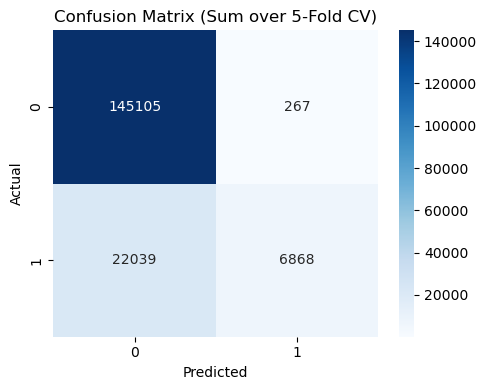

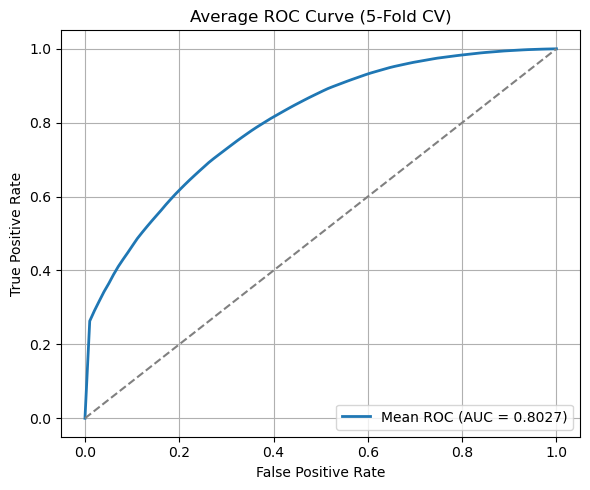

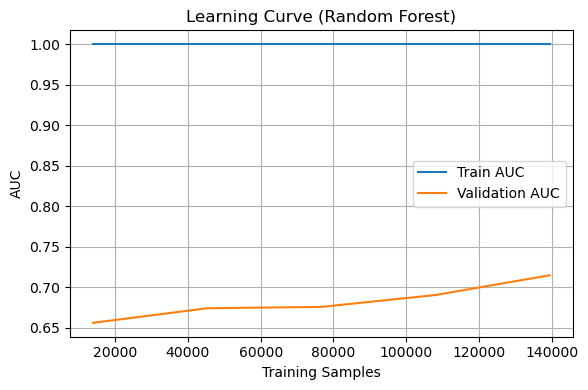

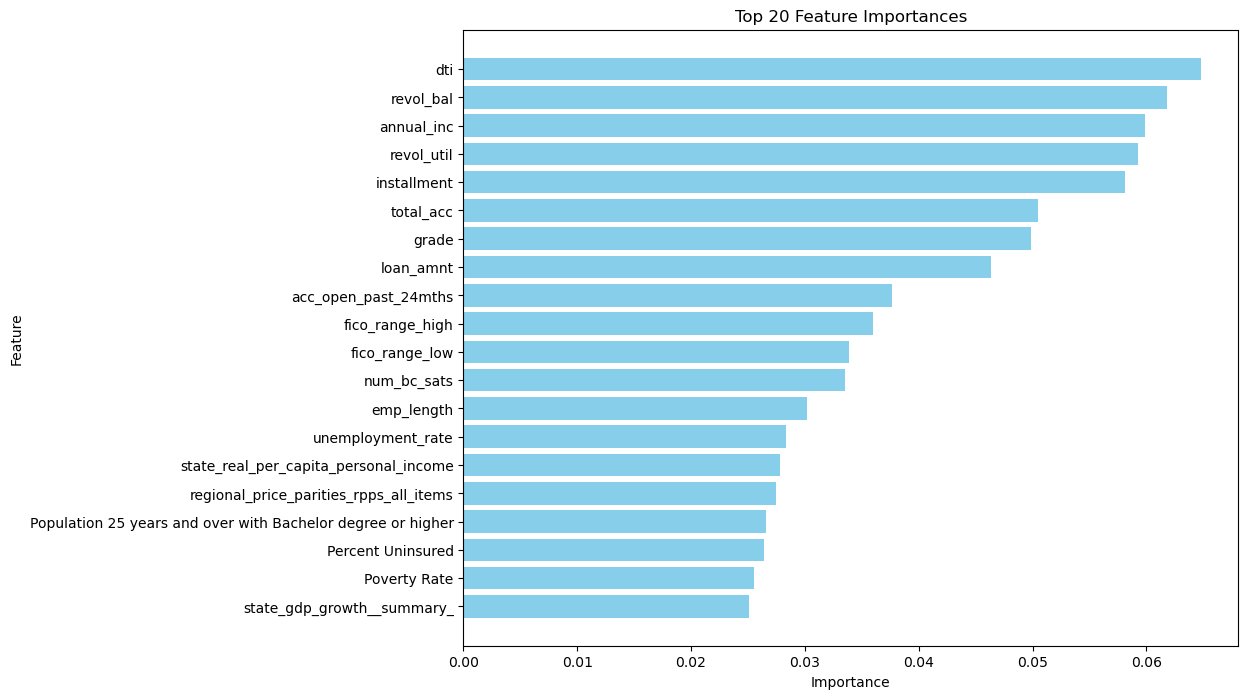

In [536]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,accuracy_score,
    confusion_matrix, roc_curve)
from sklearn.model_selection import learning_curve
train_df = pd.read_csv("Final_v3.csv")

# 检查目标变量是否平衡
class_counts = train_df['loan_status'].value_counts(normalize=True)
print("\n===== loan_status Distribution =====")
print(class_counts)

# 判断是否需要 class_weight
use_class_weight = class_counts.min() < 0.4
print(f"\nUsing class_weight='balanced': {use_class_weight}")

# 拆分特征与目标变量（排除 id）
X = train_df.drop(columns=['loan_status'])
y = train_df['loan_status']

# 初始化模型
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced' if use_class_weight else None
)

# 初始化交叉验证器
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 存储评估指标
auc_scores, f1_scores, precision_scores, recall_scores, accuracy_scores = [], [], [], [], []
conf_matrix_sum = np.zeros((2, 2), dtype=int)
mean_fpr = np.linspace(0, 1, 100)
tprs = []

# 执行交叉验证
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    y_prob = rf.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_prob)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)

    auc_scores.append(auc)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    accuracy_scores.append(accuracy)
    conf_matrix_sum += cm

    fpr, tpr, _ = roc_curve(y_val, y_prob)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

    print(f"\nFold {fold} | AUC: {auc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | Accuracy: {accuracy:.4f}")


# 汇总评估指标
print("\n===== Cross-Validation Metrics (5-Fold) =====")
print(f"Mean AUC       : {np.mean(auc_scores):.4f}")
print(f"Mean Accuracy  : {np.mean(accuracy_scores):.4f}")
print(f"Mean F1 Score  : {np.mean(f1_scores):.4f}")
print(f"Mean Precision : {np.mean(precision_scores):.4f}")
print(f"Mean Recall    : {np.mean(recall_scores):.4f}")

# 混淆矩阵可视化
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_sum, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Sum over 5-Fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC 曲线可视化（平均）
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0

plt.figure(figsize=(6, 5))
plt.plot(mean_fpr, mean_tpr, label=f"Mean ROC (AUC = {np.mean(auc_scores):.4f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curve (5-Fold CV)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


train_sizes, train_scores, val_scores = learning_curve(
    rf, X, y, cv=5, scoring='roc_auc', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train AUC')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation AUC')
plt.xlabel("Training Samples")
plt.ylabel("AUC")
plt.title("Learning Curve (Random Forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
feature_names = X.columns

# 获取特征重要性分数
importances = rf.feature_importances_

# 创建包含特征名称和重要性分数的数据框
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 按重要性分数降序排列，并选择前20个特征
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# 可视化
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # 反转Y轴，使得最重要的特征在顶部
plt.show()

# Best Thresholds for F1 Finding Process

Fold | Best Thresh | Max F1 | Recall | Precision | Accuracy | AUC
---------------------------------------------------------------------------
 1   | 0.20         | 0.4669 | 0.6335 | 0.3697 | 0.7601  | 0.8027
 2   | 0.20         | 0.4632 | 0.6248 | 0.3680 | 0.7598  | 0.7996
 3   | 0.20         | 0.4709 | 0.6517 | 0.3686 | 0.7570  | 0.8035
 4   | 0.20         | 0.4692 | 0.6380 | 0.3711 | 0.7606  | 0.8053
 5   | 0.20         | 0.4707 | 0.6383 | 0.3728 | 0.7619  | 0.8023

===== Summary =====
Mean F1      : 0.4682
Avg Accuracy : 0.7599
Avg Best Th  : 0.20


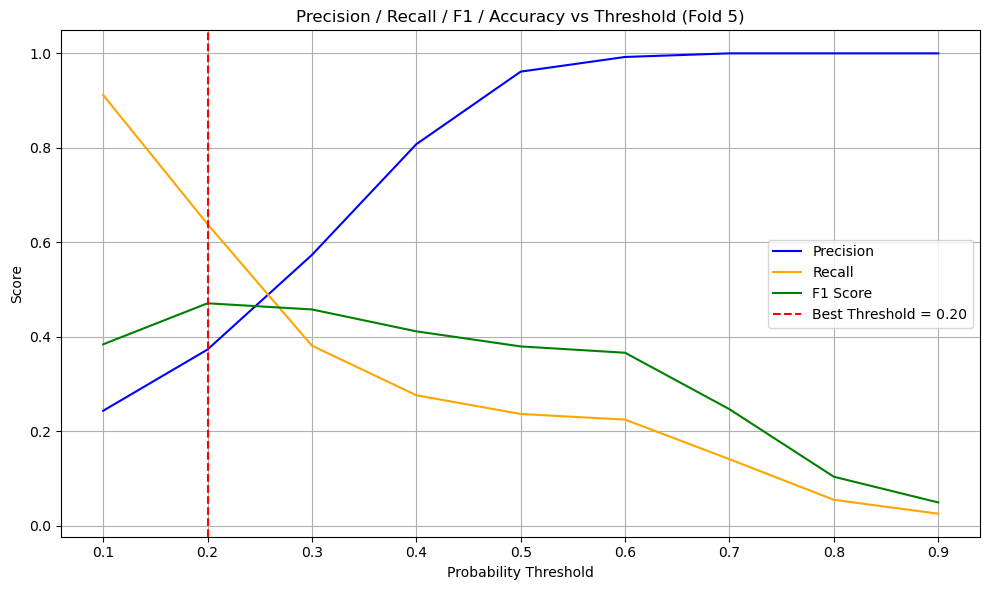

In [532]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
)

# === 数据读取与准备 ===
df = pd.read_csv("Final_v3.csv")
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# === 初始化模型 ===
rf = RandomForestClassifier(
    n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'
)

# === 设置交叉验证与阈值范围 ===
thresholds = np.linspace(0.1, 0.9, 9)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === 存储结果 ===
best_thresholds = []
f1_by_threshold = []
accuracy_scores = []

print("Fold | Best Thresh | Max F1 | Recall | Precision | Accuracy | AUC")
print("-" * 75)

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    rf.fit(X_train, y_train)
    y_prob = rf.predict_proba(X_val)[:, 1]

    # 搜索最佳 F1 对应的阈值
    best_f1 = 0
    best_t = 0.5
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        f1 = f1_score(y_val, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t

    # 最佳阈值对应结果
    y_final = (y_prob >= best_t).astype(int)
    recall = recall_score(y_val, y_final)
    precision = precision_score(y_val, y_final)
    accuracy = accuracy_score(y_val, y_final)
    auc = roc_auc_score(y_val, y_prob)

    best_thresholds.append(best_t)
    f1_by_threshold.append(best_f1)
    accuracy_scores.append(accuracy)

    print(f"{fold:^4} | {best_t:.2f}         | {best_f1:.4f} | {recall:.4f} | {precision:.4f} | {accuracy:.4f}  | {auc:.4f}")

    # ✅ 记录最后一折结果用于画图
    if fold == 5:
        last_probs = y_prob
        last_labels = y_val

# === 汇总结果 ===
print("\n===== Summary =====")
print(f"Mean F1      : {np.mean(f1_by_threshold):.4f}")
print(f"Avg Accuracy : {np.mean(accuracy_scores):.4f}")
print(f"Avg Best Th  : {np.mean(best_thresholds):.2f}")

# === 绘图：Precision / Recall / F1 / Accuracy vs Threshold ===
precisions, recalls, f1s, accuracies = [], [], [], []

for t in thresholds:
    y_pred = (last_probs >= t).astype(int)
    precisions.append(precision_score(last_labels, y_pred, zero_division=0))
    recalls.append(recall_score(last_labels, y_pred, zero_division=0))
    f1s.append(f1_score(last_labels, y_pred, zero_division=0))
    accuracies.append(accuracy_score(last_labels, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='orange')
plt.plot(thresholds, f1s, label='F1 Score', color='green')

# 红线标记当前阈值（以 Fold 5 最佳为例）
best_threshold = best_thresholds[-1]
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')

plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title('Precision / Recall / F1 / Accuracy vs Threshold (Fold 5)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 无交互变量仅用F1最优调节阀值0.2结果


Using class_weight='balanced': True

Fold 1 | AUC: 0.8027 | F1: 0.4669 | Precision: 0.3697 | Recall: 0.6335 | Accuracy: 0.7601

Fold 2 | AUC: 0.7996 | F1: 0.4632 | Precision: 0.3680 | Recall: 0.6248 | Accuracy: 0.7598

Fold 3 | AUC: 0.8035 | F1: 0.4709 | Precision: 0.3686 | Recall: 0.6517 | Accuracy: 0.7570

Fold 4 | AUC: 0.8053 | F1: 0.4692 | Precision: 0.3711 | Recall: 0.6380 | Accuracy: 0.7606

Fold 5 | AUC: 0.8023 | F1: 0.4707 | Precision: 0.3728 | Recall: 0.6383 | Accuracy: 0.7619

===== Cross-Validation Metrics (Best of 5-Fold) =====
Mean AUC       : 0.8027
Mean Accuracy  : 0.7310
Mean F1 Score  : 0.4682
Mean Precision : 0.3700
Mean Recall    : 0.6372


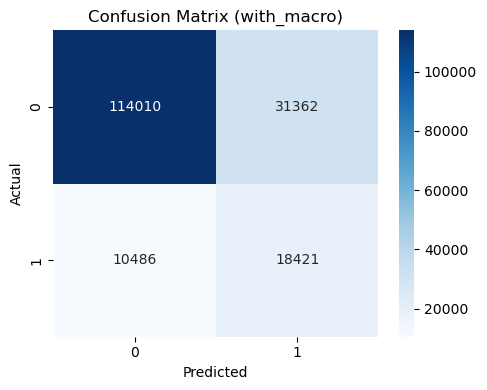

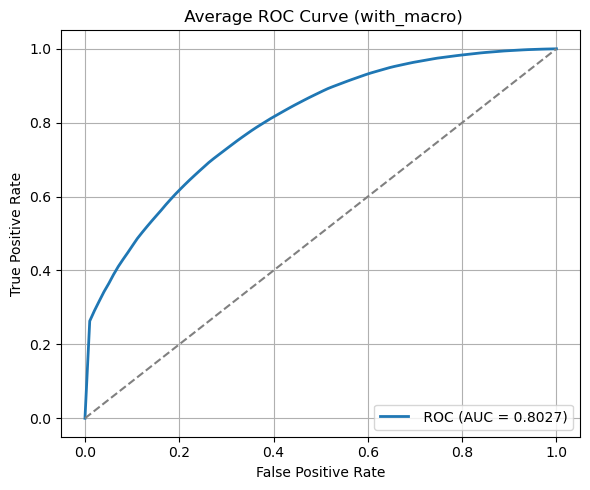

Model saved to rf_model4.pkl
===== Top 20 Feature Importances =====
                                              feature  importance  rank
0                                                 dti    0.064833     1
1                                           revol_bal    0.061765     2
2                                          annual_inc    0.059879     3
3                                          revol_util    0.059266     4
4                                         installment    0.058074     5
5                                           total_acc    0.050451     6
6                                               grade    0.049887     7
7                                           loan_amnt    0.046300     8
8                                acc_open_past_24mths    0.037632     9
9                                     fico_range_high    0.035956    10
10                                     fico_range_low    0.033883    11
11                                        num_bc_sats    0.033501   

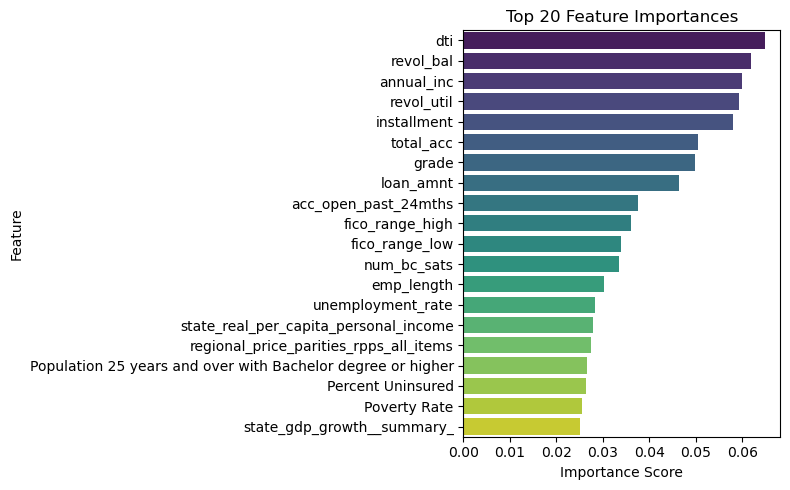

In [605]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_curve
)

df = pd.read_csv("Final_v3.csv")
X = df.drop(columns=['loan_status'])
y = df['loan_status']

use_class_weight = y.value_counts(normalize=True).min() < 0.4
print(f"\nUsing class_weight='balanced': {use_class_weight}")

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced' if use_class_weight else None
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores, f1_scores, precision_scores, recall_scores = [], [], [], []
conf_matrix_sum = np.zeros((2, 2), dtype=int)
mean_fpr = np.linspace(0, 1, 100)
tprs = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    rf.fit(X_train, y_train)
    y_prob = rf.predict_proba(X_val)[:, 1]
    y_pred = (y_prob >= 0.2).astype(int)

    auc = roc_auc_score(y_val, y_prob)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)

    auc_scores.append(auc)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    accuracy_scores.append(accuracy)
    conf_matrix_sum += cm

    fpr, tpr, _ = roc_curve(y_val, y_prob)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

    print(f"\nFold {fold} | AUC: {auc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | Accuracy: {accuracy:.4f}")

print("\n===== Cross-Validation Metrics (Best of 5-Fold) =====")
print(f"Mean AUC       : {np.mean(auc_scores):.4f}")
print(f"Mean Accuracy  : {np.mean(accuracy_scores):.4f}")
print(f"Mean F1 Score  : {np.mean(f1_scores):.4f}")
print(f"Mean Precision : {np.mean(precision_scores):.4f}")
print(f"Mean Recall    : {np.mean(recall_scores):.4f}")

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_sum, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (with_macro)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
plt.figure(figsize=(6, 5))
plt.plot(mean_fpr, mean_tpr, label=f" ROC (AUC = {np.mean(auc_scores):.4f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(" Average ROC Curve (with_macro)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

joblib.dump(rf, "rf_model4.pkl")
print("Model saved to rf_model4.pkl")

importances = rf.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_df_sorted = feat_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
feat_df_sorted['rank'] = feat_df_sorted.index + 1
top20 = feat_df_sorted.head(20)
print("===== Top 20 Feature Importances =====")
print(top20)

plt.figure(figsize=(8, 5))
sns.barplot(x='importance', y='feature', data=top20, palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("top20_features_rf.png")
plt.show()

# Test dataset（F1 最优阀值 0.2结果）


===== Test Performance =====
AUC       : 0.6640
Accuracy  : 0.7476
F1 Score  : 0.2431
Precision : 0.1693
Recall    : 0.4308
Confusion Matrix:
 [[91523 25738]
 [ 6931  5246]]


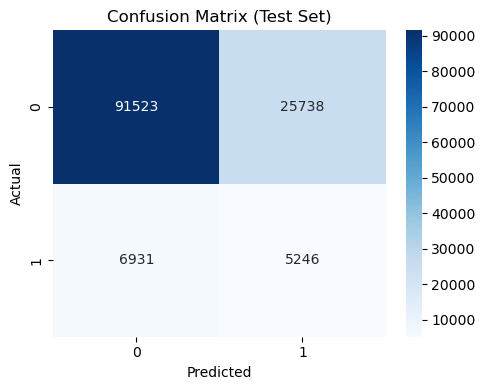

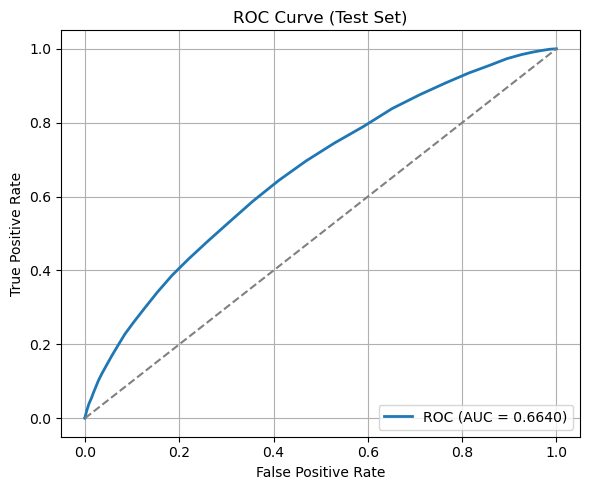

In [520]:
# === Load test set ===
test_df = pd.read_csv("Final_test_v3.csv")
X_test = test_df.drop(columns=["loan_status"])
y_test = test_df["loan_status"]

# === Load trained model ===
rf = joblib.load("rf_model4.pkl")

# === Impute missing values ===
X_test = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(X_test), columns=X_test.columns)

# === Align feature order ===
X_test = X_test[rf.feature_names_in_]

# === Predict ===
y_prob = rf.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.2).astype(int)

# === Metrics ===
auc = roc_auc_score(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)  
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_prob)

print("\n===== Test Performance =====")
print(f"AUC       : {auc:.4f}")
print(f"Accuracy  : {accuracy:.4f}") 
print(f"F1 Score  : {f1:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print("Confusion Matrix:\n", cm)


# === Plot confusion matrix ===
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === Plot ROC curve ===
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.4f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 超参数调优找 AUC及最佳threshold（F1）

Loading data...

Using class_weight='balanced': True

Starting RandomizedSearchCV (AUC)...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best AUC Score: 0.7170987051322159
Best Parameters: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}

Fold 1 | Best Thresh: 0.2188 | F1: 0.4833 | Precision: 0.4185 | Recall: 0.5719 | AUC: 0.8126

Fold 2 | Best Thresh: 0.2387 | F1: 0.4803 | Precision: 0.4544 | Recall: 0.5094 | AUC: 0.8091

Fold 3 | Best Thresh: 0.2362 | F1: 0.4919 | Precision: 0.4550 | Recall: 0.5355 | AUC: 0.8139

Fold 4 | Best Thresh: 0.2025 | F1: 0.4833 | Precision: 0.3963 | Recall: 0.6193 | AUC: 0.8144

Fold 5 | Best Thresh: 0.2525 | F1: 0.4854 | Precision: 0.4878 | Recall: 0.4830 | AUC: 0.8133

===== Per-Fold Best Results =====
   fold  threshold       auc        f1  precision    recall
0     1    0.21875  0.812598  0.483333   0.418534  0.571873
1     2    0.23875  0.809066  0.480346   0.454405  0.50942

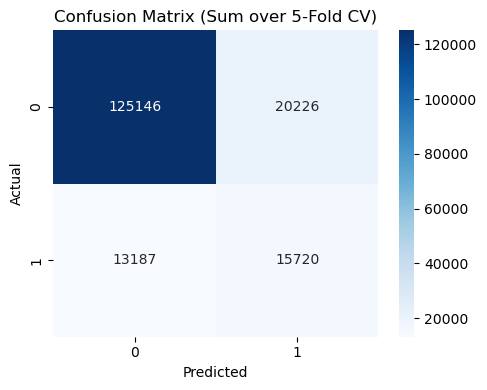

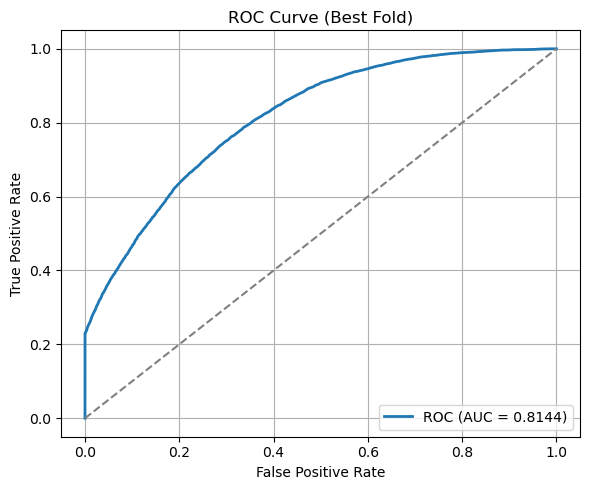


===== Top 20 Feature Importances =====
                                              feature  importance  rank
0                                                 dti    0.065281     1
1                                           revol_bal    0.061756     2
2                                          annual_inc    0.059777     3
3                                          revol_util    0.059246     4
4                                         installment    0.058229     5
5                                               grade    0.052562     6
6                                           total_acc    0.050043     7
7                                           loan_amnt    0.046539     8
8                                acc_open_past_24mths    0.037637     9
9                                     fico_range_high    0.034921    10
10                                     fico_range_low    0.033968    11
11                                        num_bc_sats    0.033218    12
12                      

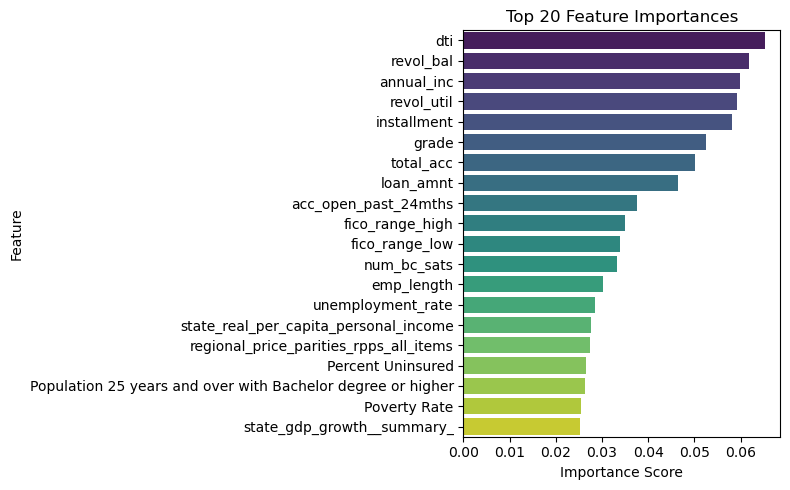

Model saved to rf_best_auc_model_thresh.pkl


In [442]:
# === Load Data
print("Loading data...")
df = pd.read_csv("Final_v3.csv")
X = df.drop(columns=["loan_status"])
y = df["loan_status"]

# === Class Balance
use_class_weight = y.value_counts(normalize=True).min() < 0.4
print("\nUsing class_weight='balanced':", use_class_weight)

# === Hyperparameter Grid
param_dist = {
    "n_estimators": [200, 400, 600, 800],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 5],
    "max_features": ["sqrt", "log2", 0.5]
}

# === RandomizedSearchCV with AUC scoring
print("\nStarting RandomizedSearchCV (AUC)...")
base_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight="balanced" if use_class_weight else None
)

search = RandomizedSearchCV(
    base_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X, y)
best_rf = search.best_estimator_
print("\nBest AUC Score:", search.best_score_)
print("Best Parameters:", search.best_params_)

# === 5-Fold CV Evaluation using best AUC model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_thresholds, best_metrics = [], []
conf_matrix_sum = np.zeros((2, 2), dtype=int)
mean_fpr = np.linspace(0, 1, 100)
tprs = []
best_auc = 0
best_auc_curve = None

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    best_rf.fit(X_train, y_train)
    y_prob = best_rf.predict_proba(X_val)[:, 1]

    # Select best threshold via F1
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_prob)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
    best_idx = np.argmax(f1s)
    best_thresh = thresholds[best_idx]
    best_thresholds.append(best_thresh)

    y_pred = (y_prob >= best_thresh).astype(int)

    auc = roc_auc_score(y_val, y_prob)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)

    best_metrics.append({
        "fold": fold,
        "threshold": best_thresh,
        "auc": auc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    })

    conf_matrix_sum += cm

    fpr, tpr, _ = roc_curve(y_val, y_prob)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

    if auc > best_auc:
        best_auc = auc
        best_auc_curve = (fpr, tpr)

    print(f"\nFold {fold} | Best Thresh: {best_thresh:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | AUC: {auc:.4f}")

# === Fold Summary
print("\n===== Per-Fold Best Results =====")
fold_results_df = pd.DataFrame(best_metrics)
print(fold_results_df)

# === Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_sum, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Sum over 5-Fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === ROC Curve (Best Fold)
best_auc_label = f"ROC (AUC = {best_auc:.4f})"
plt.figure(figsize=(6, 5))
plt.plot(best_auc_curve[0], best_auc_curve[1], label=best_auc_label, lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Best Fold)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_best_auc_single.png")
plt.show()

# === Feature Importances
importances = best_rf.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_df_sorted = feat_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
feat_df_sorted['rank'] = feat_df_sorted.index + 1

print("\n===== Top 20 Feature Importances =====")
top20 = feat_df_sorted.head(20)
print(top20)

plt.figure(figsize=(8, 5))
sns.barplot(x='importance', y='feature', data=top20, palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("top20_features_rf_auc_threshold.png")
plt.show()

# === Save model
joblib.dump(best_rf, "rf_best_auc_model_thresh.pkl")
print("Model saved to rf_best_auc_model_thresh.pkl")

# 最佳超参数及最优F1阀值结果

Fold | Threshold | F1 | Precision | Recall | Accuracy | AUC
-----------------------------------------------------------------
 1   | 0.21875 | 0.4833 | 0.4185 | 0.5719 | 0.7972 | 0.8126
 2   | 0.23875 | 0.4803 | 0.4544 | 0.5094 | 0.8172 | 0.8091
 3   | 0.23625 | 0.4919 | 0.4550 | 0.5355 | 0.8165 | 0.8139
 4   | 0.20250 | 0.4833 | 0.3963 | 0.6193 | 0.7803 | 0.8144
 5   | 0.25250 | 0.4854 | 0.4878 | 0.4830 | 0.8301 | 0.8133

===== Mean Cross-Validation Metrics (5-Fold) =====
Mean Threshold : 0.2297
Mean F1 Score  : 0.4849
Mean Precision : 0.4424
Mean Recall    : 0.5438
Mean Accuracy  : 0.8083
Mean AUC       : 0.8127


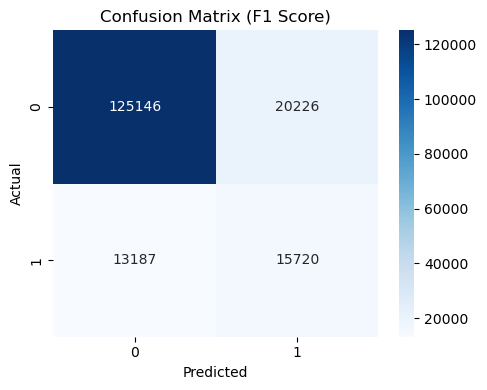

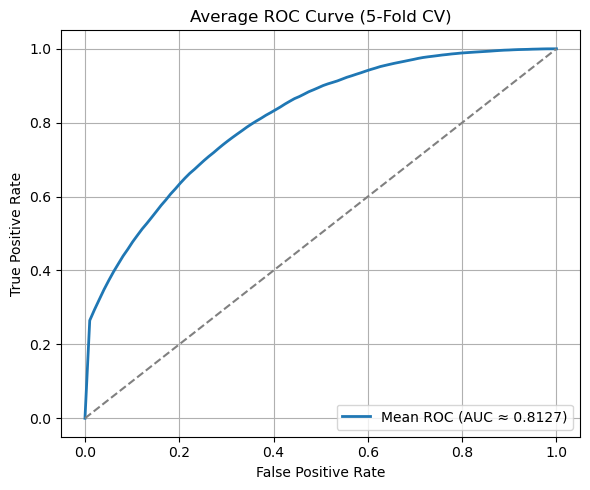

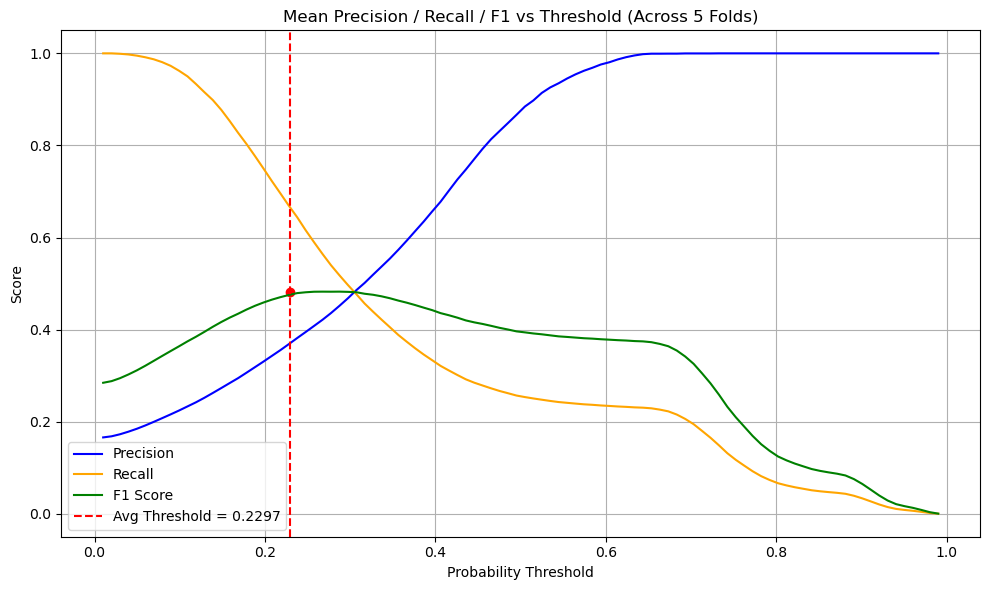

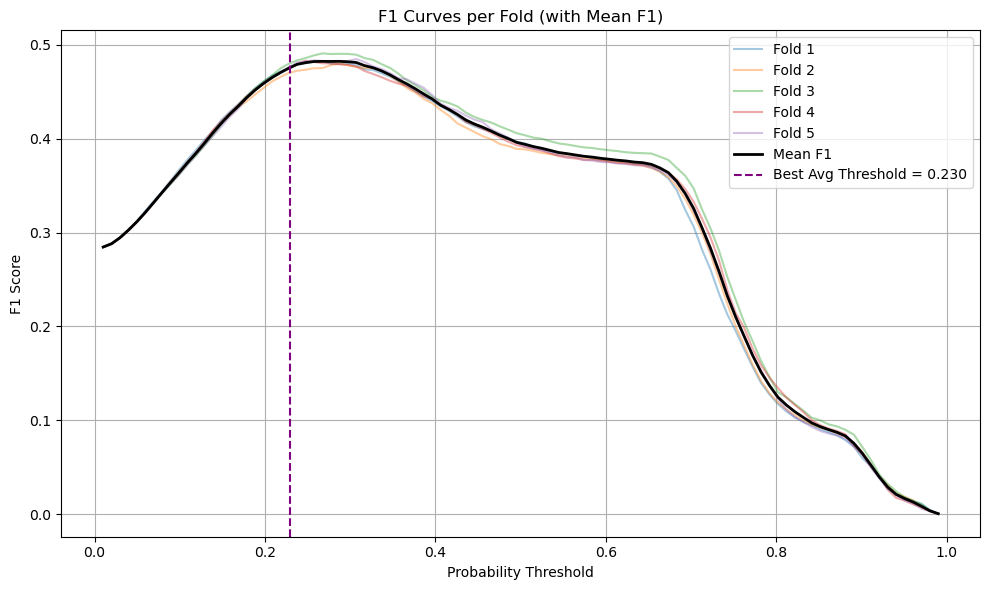

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_curve, accuracy_score, precision_recall_curve
)

# === Load Data ===
df = pd.read_csv("Final_v3.csv")
X = df.drop(columns=["loan_status"])
y = df["loan_status"]

# === Model Setup ===
rf = RandomForestClassifier(
    n_estimators=800,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
conf_matrix_sum = np.zeros((2, 2), dtype=int)
tprs, all_metrics = [], []
mean_fpr = np.linspace(0, 1, 100)

pr_thresholds = np.linspace(0.01, 0.99, 100)
prc_interp_all = []
rec_interp_all = []
f1_interp_all = []

print("Fold | Threshold | F1 | Precision | Recall | Accuracy | AUC")
print("-" * 65)

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    rf.fit(X_train, y_train)
    y_prob = rf.predict_proba(X_val)[:, 1]

    prc, rec, thresholds = precision_recall_curve(y_val, y_prob)
    f1s = 2 * (prc * rec) / (prc + rec + 1e-6)

    best_idx = np.argmax(f1s)
    best_thresh = thresholds[best_idx]

    y_pred = (y_prob >= best_thresh).astype(int)

    auc = roc_auc_score(y_val, y_prob)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)

    cm = confusion_matrix(y_val, y_pred)
    conf_matrix_sum += cm

    fpr, tpr, _ = roc_curve(y_val, y_prob)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

    all_metrics.append([best_thresh, f1, precision, recall, accuracy, auc])

    # === Interpolate precision/recall/f1 to fixed thresholds ===
    t_len = len(thresholds)
    # match threshold length
    prc_i = np.interp(pr_thresholds, np.linspace(0.01, 0.99, t_len), prc[:-1])
    rec_i = np.interp(pr_thresholds, np.linspace(0.01, 0.99, t_len), rec[:-1])
    f1_i = np.interp(pr_thresholds, np.linspace(0.01, 0.99, t_len), f1s[:-1])

    prc_interp_all.append(prc_i)
    rec_interp_all.append(rec_i)
    f1_interp_all.append(f1_i)

    print(f"{fold:^4} | {best_thresh:.5f} | {f1:.4f} | {precision:.4f} | {recall:.4f} | {accuracy:.4f} | {auc:.4f}")

# === Compute Mean Metrics ===
metrics = np.array(all_metrics)
avg_thresh, avg_f1, avg_precision, avg_recall, avg_accuracy, avg_auc = metrics.mean(axis=0)

print("\n===== Mean Cross-Validation Metrics (5-Fold) =====")
print(f"Mean Threshold : {avg_thresh:.4f}")
print(f"Mean F1 Score  : {avg_f1:.4f}")
print(f"Mean Precision : {avg_precision:.4f}")
print(f"Mean Recall    : {avg_recall:.4f}")
print(f"Mean Accuracy  : {avg_accuracy:.4f}")
print(f"Mean AUC       : {avg_auc:.4f}")

# === Confusion Matrix ===
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_sum, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (F1 Score)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === ROC Curve ===
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
plt.figure(figsize=(6, 5))
plt.plot(mean_fpr, mean_tpr, label=f"Mean ROC (AUC ≈ {avg_auc:.4f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curve (5-Fold CV)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# === PR-F1 Curve (Mean over Folds using Interpolated Thresholds) ===
mean_prc = np.mean(prc_interp_all, axis=0)
mean_rec = np.mean(rec_interp_all, axis=0)
mean_f1s = np.mean(f1_interp_all, axis=0)

best_idx = np.argmax(mean_f1s)
best_thresh = 0.2297
plt.figure(figsize=(10, 6))
plt.plot(pr_thresholds, mean_prc, label='Precision', color='blue')
plt.plot(pr_thresholds, mean_rec, label='Recall', color='orange')
plt.plot(pr_thresholds, mean_f1s, label='F1 Score', color='green')
plt.axvline(best_thresh, color='red', linestyle='--', label=f'Avg Threshold = 0.2297')
plt.scatter(0.2297, mean_f1s[best_idx], color='red')

plt.title("Mean Precision / Recall / F1 vs Threshold (Across 5 Folds)")
plt.xlabel("Probability Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Diagnostic: Overlay each fold's F1 Score ===
plt.figure(figsize=(10, 6))
for i, f1s in enumerate(f1_interp_all):
    plt.plot(pr_thresholds, f1s, alpha=0.4, label=f"Fold {i+1}")
plt.plot(pr_thresholds, mean_f1s, color='black', lw=2, label="Mean F1")
plt.axvline(best_thresh, linestyle='--', color='purple', label=f"Best Avg Threshold = {best_thresh:.3f}")
plt.title("F1 Curves per Fold (with Mean F1)")
plt.xlabel("Probability Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# G-Means 调最佳threshold

Fold | Threshold | G-Mean | Precision | Recall | Accuracy | AUC
----------------------------------------------------------------------
 1   | 0.16838 | 0.7237 | 0.3420 | 0.7246 | 0.7231 | 0.8126
 2   | 0.16838 | 0.7192 | 0.3398 | 0.7144 | 0.7224 | 0.8091
 3   | 0.16838 | 0.7261 | 0.3404 | 0.7359 | 0.7196 | 0.8139
 4   | 0.15848 | 0.7248 | 0.3291 | 0.7587 | 0.7034 | 0.8144
 5   | 0.16838 | 0.7249 | 0.3414 | 0.7298 | 0.7217 | 0.8133

===== Mean Cross-Validation Metrics (5-Fold) =====
Mean Threshold : 0.1664
Mean G-Mean    : 0.7237
Mean Precision : 0.3385
Mean Recall    : 0.7327
Mean Accuracy  : 0.7180
Mean AUC       : 0.8127


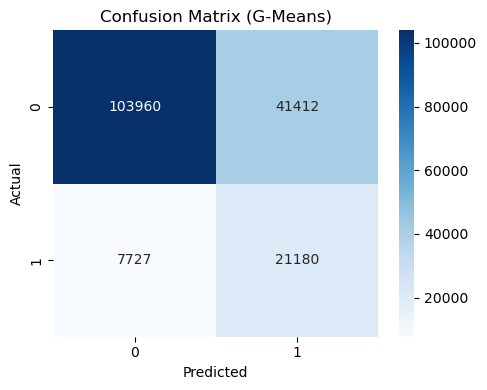

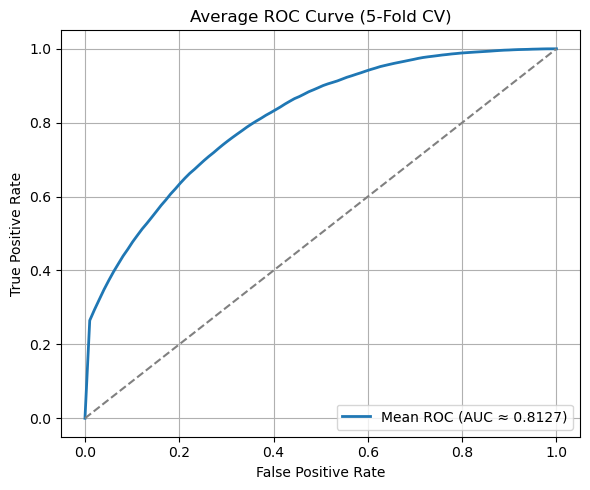

Model saved to rf_best_auc_model_thresh.pkl


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score,
    accuracy_score, confusion_matrix, roc_curve
)

# === Load Data ===
df = pd.read_csv("Final_v3.csv")  # <-- 请确认路径正确或重新上传文件
X = df.drop(columns=["loan_status"])
y = df["loan_status"]

# === Model Setup ===
rf = RandomForestClassifier(
    n_estimators=800,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
conf_matrix_sum = np.zeros((2, 2), dtype=int)
tprs = []
mean_fpr = np.linspace(0, 1, 100)
threshold_range = np.linspace(0.01, 0.99, 100)
all_metrics = []

print("Fold | Threshold | G-Mean | Precision | Recall | Accuracy | AUC")
print("-" * 70)

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    rf.fit(X_train, y_train)
    y_prob = rf.predict_proba(X_val)[:, 1]

    best_gmean = 0
    best_thresh = 0.5
    for thresh in threshold_range:
        y_pred_temp = (y_prob >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred_temp).ravel()
        tpr = tp / (tp + fn + 1e-6)
        tnr = tn / (tn + fp + 1e-6)
        gmean = np.sqrt(tpr * tnr)
        if gmean > best_gmean:
            best_gmean = gmean
            best_thresh = thresh

    y_pred = (y_prob >= best_thresh).astype(int)

    auc = roc_auc_score(y_val, y_prob)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)

    cm = confusion_matrix(y_val, y_pred)
    conf_matrix_sum += cm

    fpr, tpr, _ = roc_curve(y_val, y_prob)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

    all_metrics.append([best_thresh, best_gmean, precision, recall, accuracy, auc])

    print(f"{fold:^4} | {best_thresh:.5f} | {best_gmean:.4f} | {precision:.4f} | {recall:.4f} | {accuracy:.4f} | {auc:.4f}")

# === Summary ===
metrics = np.array(all_metrics)
avg_thresh, avg_gmean, avg_precision, avg_recall, avg_accuracy, avg_auc = metrics.mean(axis=0)

print("\n===== Mean Cross-Validation Metrics (5-Fold) =====")
print(f"Mean Threshold : {avg_thresh:.4f}")
print(f"Mean G-Mean    : {avg_gmean:.4f}")
print(f"Mean Precision : {avg_precision:.4f}")
print(f"Mean Recall    : {avg_recall:.4f}")
print(f"Mean Accuracy  : {avg_accuracy:.4f}")
print(f"Mean AUC       : {avg_auc:.4f}")

# === Confusion Matrix ===
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_sum, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (G-Means)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === ROC Curve ===
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
plt.figure(figsize=(6, 5))
plt.plot(mean_fpr, mean_tpr, label=f"Mean ROC (AUC ≈ {avg_auc:.4f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curve (5-Fold CV)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
# === Save model
joblib.dump(rf, "rf_best_auc_model_thresh.pkl")
print("Model saved to rf_best_auc_model_thresh.pkl")

# 根据g-means调优及最佳超参数测试结果


===== Test Performance =====
AUC       : 0.6872
F1 Score  : 0.2497
Precision : 0.1587
Recall    : 0.5845
Confusion Matrix:
 [[79533 37728]
 [ 5059  7118]]


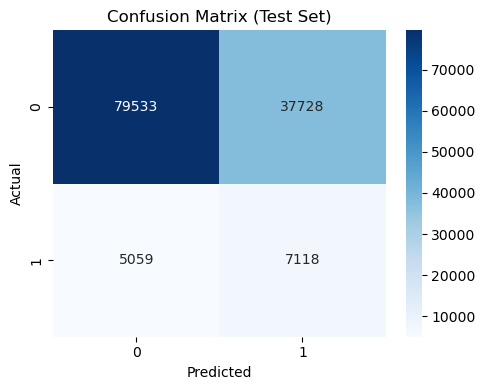

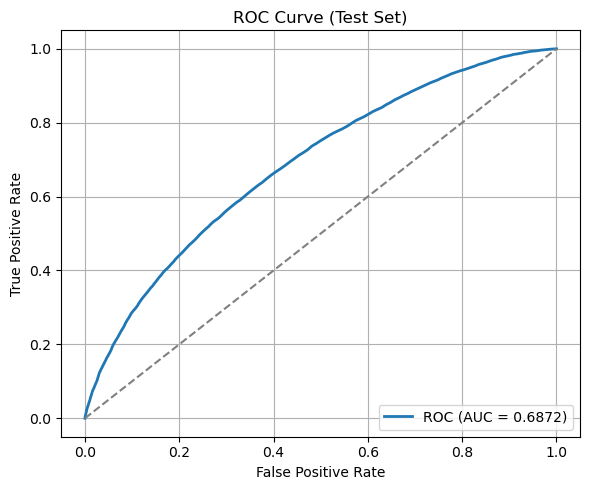

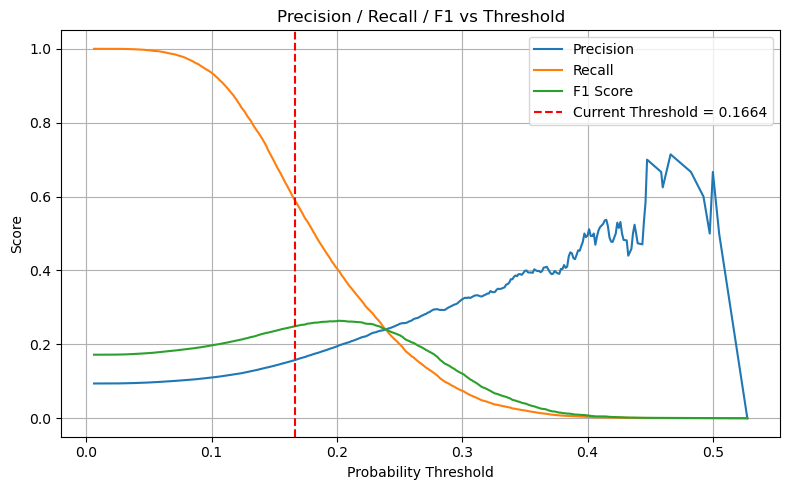

In [35]:
# === Load trained model ===
rf = joblib.load("rf_best_auc_model_thresh.pkl")

# === Load test set ===
test_df = pd.read_csv("Final_test_v3.csv")
y_test = test_df["loan_status"]
X_test = test_df.drop(columns=["loan_status", "id"], errors="ignore")

# === Drop addr_state if not used in training ===
if 'addr_state' in X_test.columns and 'addr_state' not in rf.feature_names_in_:
    X_test = X_test.drop(columns=["addr_state"])


# === Align feature order with training ===
X_test = X_test[rf.feature_names_in_]

# === Predict ===
y_prob = rf.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.1664).astype(int)

# === Metrics ===
auc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_prob)

print("\n===== Test Performance =====")
print(f"AUC       : {auc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print("Confusion Matrix:\n", cm)

# === Plot Confusion Matrix ===
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === Plot ROC Curve ===
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.4f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot Threshold - Precision / Recall / F1 ===
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.plot(thresholds, f1s[:-1], label='F1 Score')
plt.axvline(0.1664, color='red', linestyle='--', label='Current Threshold = 0.1664')

plt.xlabel("Probability Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 去掉宏观变量消融实验


Using class_weight='balanced': True

Fold 1 | AUC: 0.8001 | F1: 0.4634 | Precision: 0.3653 | Recall: 0.6335

Fold 2 | AUC: 0.8013 | F1: 0.4630 | Precision: 0.3662 | Recall: 0.6291

Fold 3 | AUC: 0.8073 | F1: 0.4756 | Precision: 0.3746 | Recall: 0.6512

Fold 4 | AUC: 0.8045 | F1: 0.4714 | Precision: 0.3713 | Recall: 0.6455

Fold 5 | AUC: 0.8053 | F1: 0.4667 | Precision: 0.3676 | Recall: 0.6388

===== Cross-Validation Metrics (Best of 5-Fold) =====
Best AUC       : 0.8073
Best F1 Score  : 0.4756
Best Precision : 0.3746
Best Recall    : 0.6512


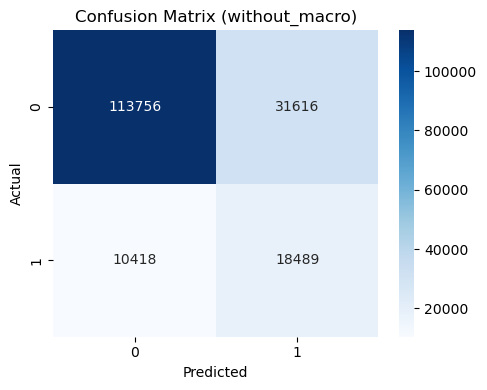

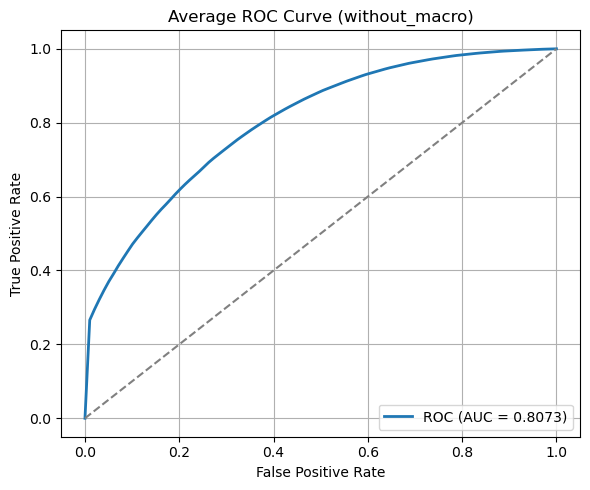

rf_model_without_macro.pkl
===== Top 20 Feature Importances =====
                 feature  importance  rank
0                    dti    0.087409     1
1              revol_bal    0.084145     2
2             revol_util    0.081351     3
3            installment    0.078479     4
4             annual_inc    0.078136     5
5              total_acc    0.067438     6
6                  grade    0.062074     7
7              loan_amnt    0.060579     8
8             addr_state    0.060524     9
9   acc_open_past_24mths    0.045982    10
10           num_bc_sats    0.044235    11
11       fico_range_high    0.042421    12
12            emp_length    0.040623    13
13        fico_range_low    0.039477    14
14            issue_year    0.024882    15
15               purpose    0.023037    16
16        inq_last_6mths    0.022276    17
17                  term    0.019805    18
18        home_ownership    0.014878    19
19   initial_list_status    0.011016    20


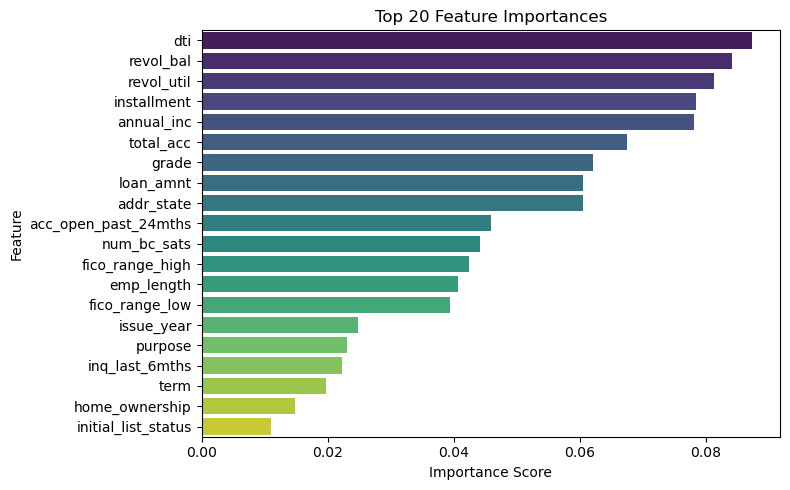

In [601]:
df = pd.read_csv("Final_v3.csv")
macro_features = [
    'Population 25 years and over with Bachelor degree or higher',
    'Percent Uninsured',
    'Poverty Rate',
    'implicit_regional_price_deflator',
    'state_per_capital_personal_consumption_expenditurespce',
    'state_total_employment_growth',
    'regional_price_parities_rpps_all_items',
    'state_gdp_growth__summary_',
    'state_real_per_capita_personal_income',
    'avg_interest_rate',
    'unemployment_rate'
]
X = df.drop(columns=['loan_status']+macro_features)
y = df['loan_status']

use_class_weight = y.value_counts(normalize=True).min() < 0.4
print(f"\nUsing class_weight='balanced': {use_class_weight}")

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced' if use_class_weight else None
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores, f1_scores, precision_scores, recall_scores = [], [], [], []
conf_matrix_sum = np.zeros((2, 2), dtype=int)
mean_fpr = np.linspace(0, 1, 100)
tprs = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    rf.fit(X_train, y_train)
    y_prob = rf.predict_proba(X_val)[:, 1]
    y_pred = (y_prob >= 0.2).astype(int)

    auc = roc_auc_score(y_val, y_prob)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)

    auc_scores.append(auc)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    conf_matrix_sum += cm

    fpr, tpr, _ = roc_curve(y_val, y_prob)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

    print(f"\nFold {fold} | AUC: {auc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

print("\n===== Cross-Validation Metrics (Best of 5-Fold) =====")
print(f"Best AUC       : {np.max(auc_scores):.4f}")
print(f"Best F1 Score  : {np.max(f1_scores):.4f}")
print(f"Best Precision : {np.max(precision_scores):.4f}")
print(f"Best Recall    : {np.max(recall_scores):.4f}")

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_sum, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (without_macro)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
plt.figure(figsize=(6, 5))
plt.plot(mean_fpr, mean_tpr, label=f"ROC (AUC = {np.max(auc_scores):.4f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curve (without_macro)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

joblib.dump(rf, "rf_model_without_macro.pkl")
print("rf_model_without_macro.pkl")

importances = rf.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_df_sorted = feat_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
feat_df_sorted['rank'] = feat_df_sorted.index + 1
top20 = feat_df_sorted.head(20)
print("===== Top 20 Feature Importances =====")
print(top20)

plt.figure(figsize=(8, 5))
sns.barplot(x='importance', y='feature', data=top20, palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("top20_features_rf.png")
plt.show()


===== Test Performance =====
AUC       : 0.6753
F1 Score  : 0.2059
Precision : 0.1166
Recall    : 0.8809
Confusion Matrix:
 [[35955 81306]
 [ 1450 10727]]


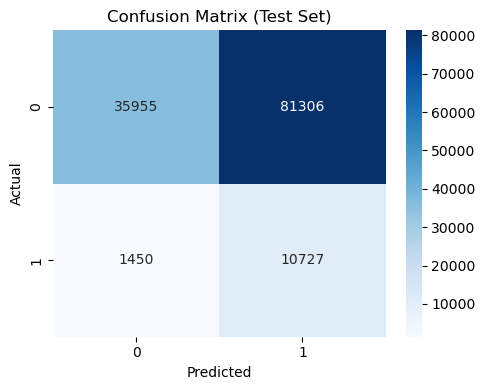

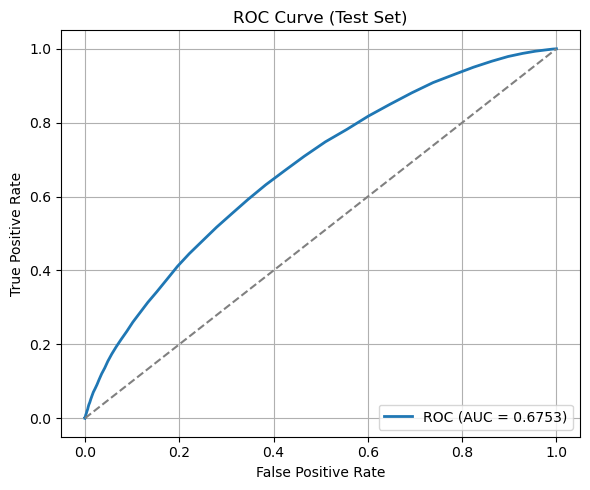

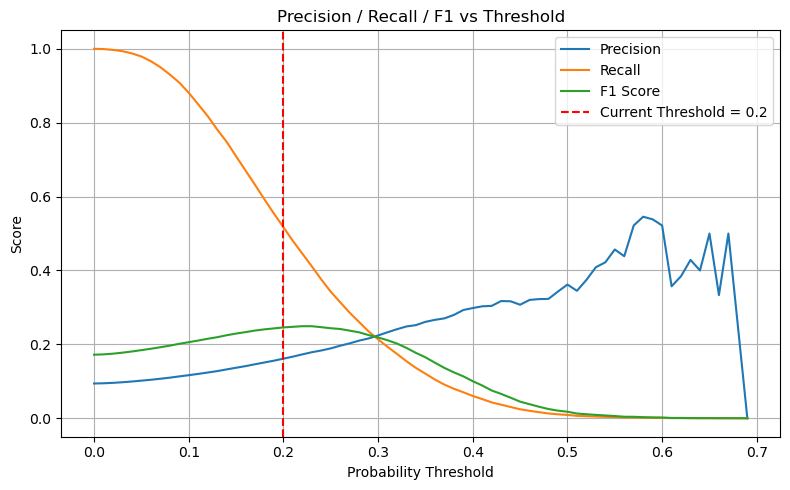

In [490]:
# === Load trained model ===
rf = joblib.load("rf_model_without_macro.pkl")

# === Load test set ===
test_df = pd.read_csv("Final_test_v3.csv")
y_test = test_df["loan_status"]
X_test = test_df.drop(columns=["loan_status", "id"]+macro_features, errors="ignore")

# === Drop addr_state if not used in training ===
if 'addr_state' in X_test.columns and 'addr_state' not in rf.feature_names_in_:
    X_test = X_test.drop(columns=["addr_state"])

# === Impute missing values ===
X_test = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(X_test), columns=X_test.columns)

# === Align feature order with training ===
X_test = X_test[rf.feature_names_in_]

# === Predict ===
y_prob = rf.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.1).astype(int)

# === Metrics ===
auc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_prob)

print("\n===== Test Performance =====")
print(f"AUC       : {auc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print("Confusion Matrix:\n", cm)

# === Plot Confusion Matrix ===
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === Plot ROC Curve ===
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.4f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot Threshold - Precision / Recall / F1 ===
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.plot(thresholds, f1s[:-1], label='F1 Score')
plt.axvline(0.2, color='red', linestyle='--', label='Current Threshold = 0.2')

plt.xlabel("Probability Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 构造交互变量，根据最优超参数还有g-means调优阀值validation结果


===== loan_status Distribution =====
loan_status
0    0.834134
1    0.165866
Name: proportion, dtype: float64

Using class_weight='balanced': True

Fold 1 | AUC: 0.8108 | F1: 0.4600 | Precision: 0.3376 | Recall: 0.7217 | Accuracy: 0.7190 | G-Mean: 0.7200

Fold 2 | AUC: 0.8083 | F1: 0.4558 | Precision: 0.3358 | Recall: 0.7092 | Accuracy: 0.7191 | G-Mean: 0.7151

Fold 3 | AUC: 0.8130 | F1: 0.4641 | Precision: 0.3379 | Recall: 0.7409 | Accuracy: 0.7161 | G-Mean: 0.7259

Fold 4 | AUC: 0.8120 | F1: 0.4619 | Precision: 0.3388 | Recall: 0.7257 | Accuracy: 0.7196 | G-Mean: 0.7220

Fold 5 | AUC: 0.8126 | F1: 0.4614 | Precision: 0.3369 | Recall: 0.7315 | Accuracy: 0.7167 | G-Mean: 0.7226

===== Cross-Validation Metrics (5-Fold) =====
Mean AUC       : 0.8113
Mean F1 Score  : 0.4606
Mean Precision : 0.3374
Mean Recall    : 0.7258
Mean Accuracy  : 0.7181
Mean G-Mean    : 0.7211


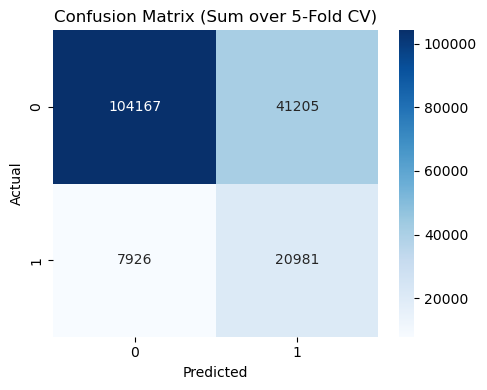

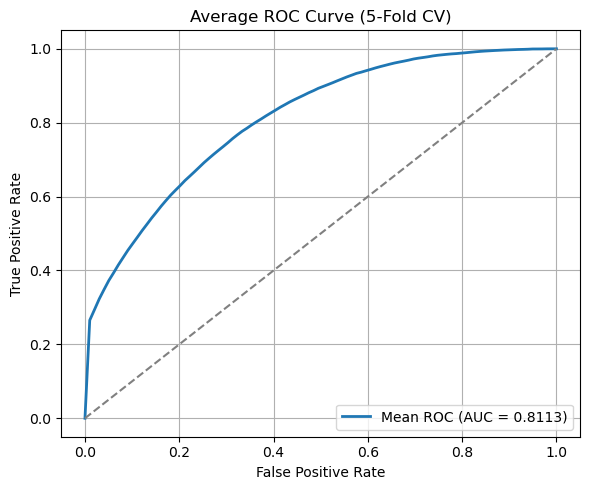

In [39]:
# Load data
train_df = pd.read_csv("Final_v3.csv")

# Add 15 interaction features
df = train_df.copy()
df['int_rate_term'] = df['avg_interest_rate'] * df['term']
df['unemp_dti'] = df['unemployment_rate'] * df['dti']
df['inflation_install'] = df['implicit_regional_price_deflator'] * df['installment']
df['edu_inc'] = df['Population 25 years and over with Bachelor degree or higher'] * df['annual_inc']
df['poverty_term'] = df['Poverty Rate'] * df['term']
df['price_purpose'] = df['regional_price_parities_rpps_all_items'] * df['purpose']
df['uninsured_dti'] = df['Percent Uninsured'] * df['dti']
df['income_bal'] = df['state_real_per_capita_personal_income'] * df['revol_bal']
df['inq_gdp'] = df['inq_last_6mths'] * df['state_gdp_growth__summary_']
df['emp_growth'] = df['emp_length'] * df['state_total_employment_growth']
df['inq_dti'] = df['inq_last_6mths'] * df['dti']
df['install_util'] = df['installment'] * df['revol_util']
df['emp_inc'] = df['emp_length'] * df['annual_inc']
df['loan_bal'] = df['loan_amnt'] * df['revol_bal']
df['term_util'] = df['term'] * df['revol_util']

# Class distribution
class_counts = df['loan_status'].value_counts(normalize=True)
print("\n===== loan_status Distribution =====")
print(class_counts)

use_class_weight = class_counts.min() < 0.4
print(f"\nUsing class_weight='balanced': {use_class_weight}")

X = df.drop(columns=['loan_status'])
y = df['loan_status']

# Best hyperparameters from tuning
rf = RandomForestClassifier(
    n_estimators=800,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced' if use_class_weight else None
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores, f1_scores, precision_scores, recall_scores, accuracy_scores, gmean_scores = [], [], [], [], [], []
conf_matrix_sum = np.zeros((2, 2), dtype=int)
mean_fpr = np.linspace(0, 1, 100)
tprs = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    rf.fit(X_train, y_train)
    y_prob = rf.predict_proba(X_val)[:, 1]
    y_pred = (y_prob >= 0.1664).astype(int)

    auc = roc_auc_score(y_val, y_prob)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    gmean = (recall * (confusion_matrix(y_val, y_pred)[0][0] / sum(confusion_matrix(y_val, y_pred)[0]))) ** 0.5
    cm = confusion_matrix(y_val, y_pred)

    auc_scores.append(auc)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    accuracy_scores.append(accuracy)
    gmean_scores.append(gmean)
    conf_matrix_sum += cm

    fpr, tpr, _ = roc_curve(y_val, y_prob)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

    print(f"\nFold {fold} | AUC: {auc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | Accuracy: {accuracy:.4f} | G-Mean: {gmean:.4f}")

print("\n===== Cross-Validation Metrics (5-Fold) =====")
print(f"Mean AUC       : {np.mean(auc_scores):.4f}")
print(f"Mean F1 Score  : {np.mean(f1_scores):.4f}")
print(f"Mean Precision : {np.mean(precision_scores):.4f}")
print(f"Mean Recall    : {np.mean(recall_scores):.4f}")
print(f"Mean Accuracy  : {np.mean(accuracy_scores):.4f}")
print(f"Mean G-Mean    : {np.mean(gmean_scores):.4f}")

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_sum, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Sum over 5-Fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
plt.figure(figsize=(6, 5))
plt.plot(mean_fpr, mean_tpr, label=f"Mean ROC (AUC = {np.mean(auc_scores):.4f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curve (5-Fold CV)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 采用smote技术解决类别不平衡


Fold 1 | AUC: 0.8036 | F1: 0.4219 | Precision: 0.6951 | Recall: 0.3029

Fold 2 | AUC: 0.8028 | F1: 0.4229 | Precision: 0.7139 | Recall: 0.3005

Fold 3 | AUC: 0.8113 | F1: 0.4351 | Precision: 0.7205 | Recall: 0.3117

Fold 4 | AUC: 0.8070 | F1: 0.4178 | Precision: 0.6910 | Recall: 0.2994

Fold 5 | AUC: 0.8060 | F1: 0.4217 | Precision: 0.7129 | Recall: 0.2994

===== Cross-Validation Metrics (5-Fold) =====
Mean AUC       : 0.8061
Mean F1 Score  : 0.4239
Mean Precision : 0.7067
Mean Recall    : 0.3028


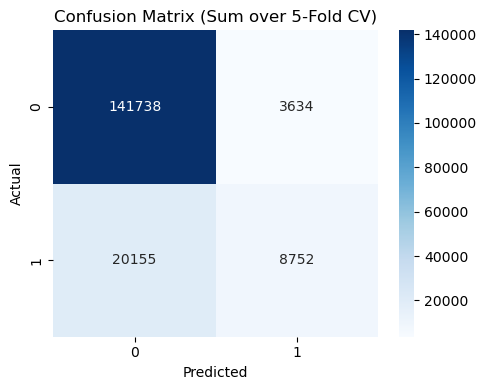

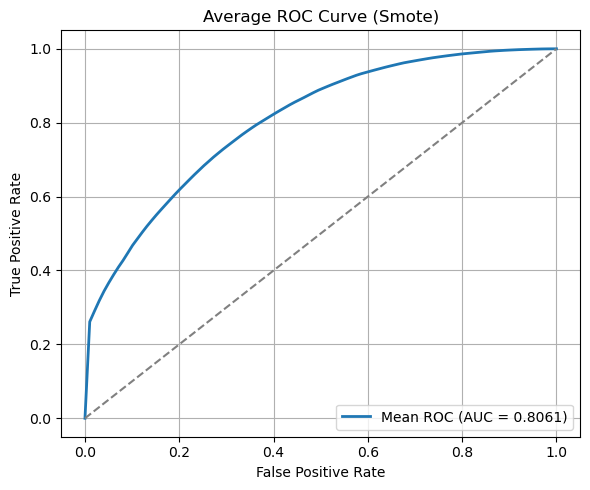

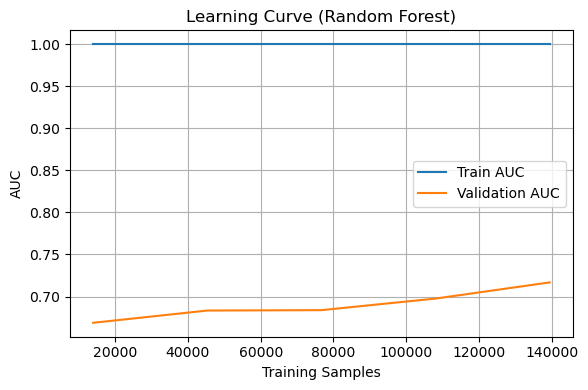

In [599]:
# RandomForest + Nested SMOTETomek + Mean Imputation for Imbalanced Classification (No Leakage)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_curve
)
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek

# === Load & preprocess ===
train_df = pd.read_csv("Final_v3.csv")
train_df = pd.get_dummies(train_df, columns=['addr_state'])

# === Drop label leakage and separate target ===
X = train_df.drop(columns=['loan_status'])
y = train_df['loan_status']

# === Impute missing values ===
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# === Initialize model & CV ===
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores, f1_scores, precision_scores, recall_scores = [], [], [], []
conf_matrix_sum = np.zeros((2, 2), dtype=int)
mean_fpr = np.linspace(0, 1, 100)
tprs = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_imputed, y), 1):
    # === Split original (non-resampled) data ===
    X_train_raw, X_val = X_imputed.iloc[train_idx], X_imputed.iloc[val_idx]
    y_train_raw, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # === Apply SMOTETomek only on training set ===
    smote_tomek = SMOTETomek(random_state=42)
    X_train, y_train = smote_tomek.fit_resample(X_train_raw, y_train_raw)

    # === Train & predict ===
    rf.fit(X_train, y_train)
    y_prob = rf.predict_proba(X_val)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    # === Metrics ===
    auc = roc_auc_score(y_val, y_prob)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)

    auc_scores.append(auc)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    conf_matrix_sum += cm

    # === ROC curve for this fold ===
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

    print(f"\nFold {fold} | AUC: {auc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

# === Cross-validation results ===
print("\n===== Cross-Validation Metrics (5-Fold) =====")
print(f"Mean AUC       : {np.mean(auc_scores):.4f}")
print(f"Mean F1 Score  : {np.mean(f1_scores):.4f}")
print(f"Mean Precision : {np.mean(precision_scores):.4f}")
print(f"Mean Recall    : {np.mean(recall_scores):.4f}")

# === Confusion Matrix (Sum over folds) ===
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_sum, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Sum over 5-Fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === Mean ROC Curve ===
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
plt.figure(figsize=(6, 5))
plt.plot(mean_fpr, mean_tpr, label=f"Mean ROC (AUC = {np.mean(auc_scores):.4f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curve (Smote)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Learning Curve (Optional: fits on whole dataset) ===
train_sizes, train_scores, val_scores = learning_curve(
    rf, X_imputed, y, cv=5, scoring='roc_auc', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train AUC')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation AUC')
plt.xlabel("Training Samples")
plt.ylabel("AUC")
plt.title("Learning Curve (Random Forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


 Model saved to rf_model.pkl
===== Top 20 Feature Importances =====
                                   feature  importance
2                                    grade    0.091930
12                    acc_open_past_24mths    0.068525
6                           inq_last_6mths    0.059390
18                         fico_range_high    0.053127
17                          fico_range_low    0.050033
14                             num_bc_sats    0.046592
15                              annual_inc    0.040918
19                              emp_length    0.039103
16                                     dti    0.038515
0                                loan_amnt    0.036302
20                             installment    0.036103
21                              revol_util    0.035056
8                                revol_bal    0.034961
9                                total_acc    0.034206
1                                     term    0.026967
3                           home_ownership    0.0266

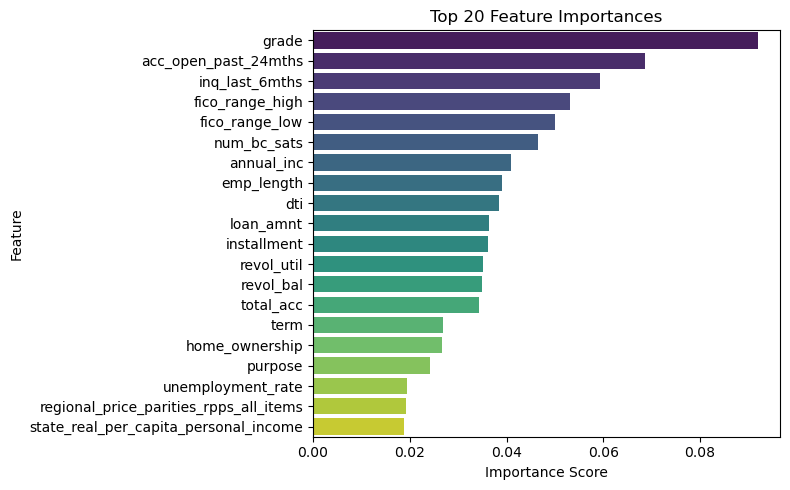

===== Macro Feature Importance Rankings =====
                                              feature  importance  rank
17                                  unemployment_rate    0.019397    18
18             regional_price_parities_rpps_all_items    0.019207    19
19              state_real_per_capita_personal_income    0.018807    20
20  Population 25 years and over with Bachelor deg...    0.018719    21
21                                  Percent Uninsured    0.018645    22
22                                       Poverty Rate    0.017976    23
23                         state_gdp_growth__summary_    0.017737    24
24                   implicit_regional_price_deflator    0.017722    25
25  state_per_capital_personal_consumption_expendi...    0.017671    26
26                      state_total_employment_growth    0.017200    27
30                                  avg_interest_rate    0.002562    31


In [328]:
import joblib
# 保存模型
joblib.dump(rf, "rf_model.pkl")
print(" Model saved to rf_model.pkl")

# 构建特征重要性 DataFrame
importances = rf.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
# 所有特征按重要性排序后加排名列
feat_df_sorted = feat_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
feat_df_sorted['rank'] = feat_df_sorted.index + 1
# Top 20 most important features
top20 = feat_df.sort_values(by='importance', ascending=False).head(20)
print("===== Top 20 Feature Importances =====")
print(top20)

# 可视化前 20 特征
plt.figure(figsize=(8, 5))
sns.barplot(x='importance', y='feature', data=top20, palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("top20_features_rf.png")
plt.show()



# 宏观变量子集 + 排名
macro_features = [
    'Population 25 years and over with Bachelor degree or higher',
    'Percent Uninsured',
    'Poverty Rate',
    'implicit_regional_price_deflator',
    'state_per_capital_personal_consumption_expenditurespce',
    'state_total_employment_growth',
    'regional_price_parities_rpps_all_items',
    'state_gdp_growth__summary_',
    'state_real_per_capita_personal_income',
    'avg_interest_rate',
    'unemployment_rate'
]

macro_df = feat_df_sorted[feat_df_sorted['feature'].isin(macro_features)] \
    .sort_values(by='importance', ascending=False)

print("===== Macro Feature Importance Rankings =====")
print(macro_df[['feature', 'importance', 'rank']])

# 以下为其他测试不用看


Fold 1 | AUC: 0.9825 | F1: 0.9369 | Precision: 0.9613 | Recall: 0.9137

Fold 2 | AUC: 0.9830 | F1: 0.9372 | Precision: 0.9631 | Recall: 0.9126

Fold 3 | AUC: 0.9829 | F1: 0.9357 | Precision: 0.9617 | Recall: 0.9112

Fold 4 | AUC: 0.9829 | F1: 0.9372 | Precision: 0.9624 | Recall: 0.9133

Fold 5 | AUC: 0.9828 | F1: 0.9380 | Precision: 0.9646 | Recall: 0.9128

===== Cross-Validation Metrics (5-Fold) =====
Mean AUC       : 0.9828
Mean F1 Score  : 0.9370
Mean Precision : 0.9626
Mean Recall    : 0.9127


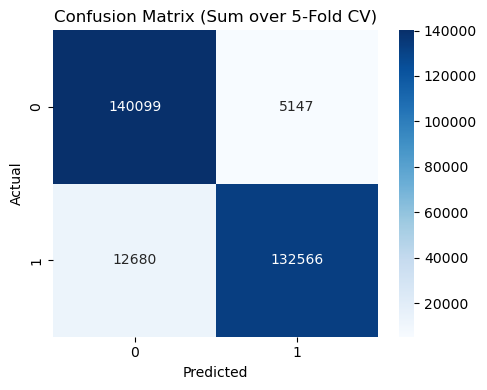

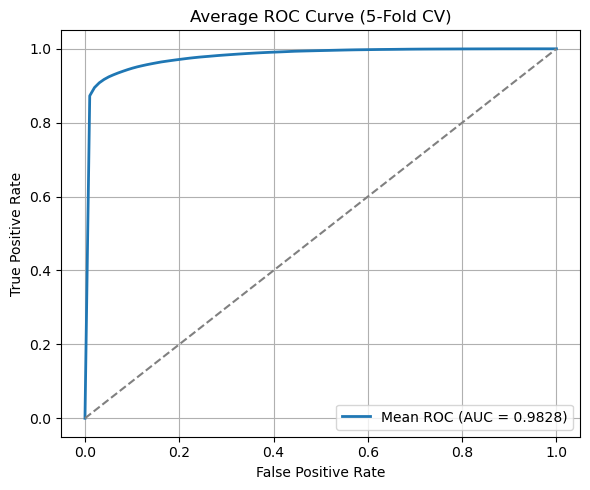

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 89,

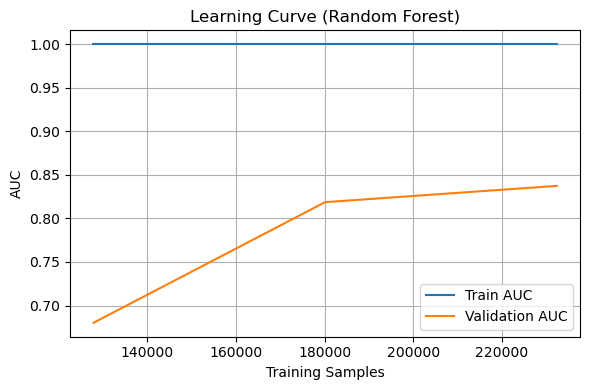

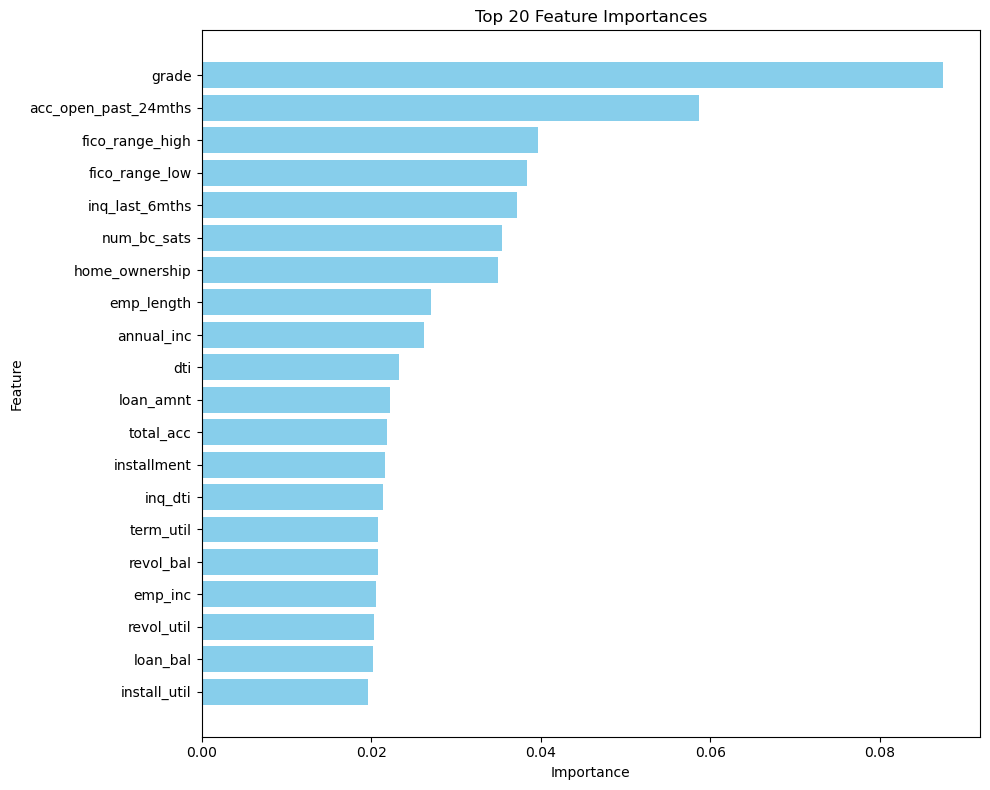


===== Test Set Performance =====
AUC       : 0.6674
F1 Score  : 0.1121
Precision : 0.2643
Recall    : 0.0711
Confusion Matrix:
 [[114851   2410]
 [ 11311    866]]


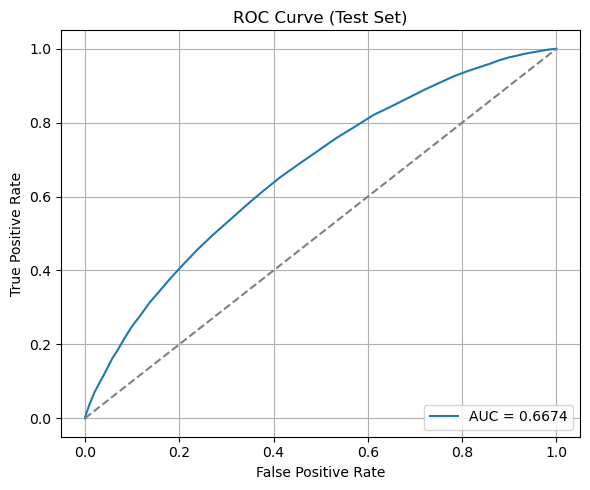

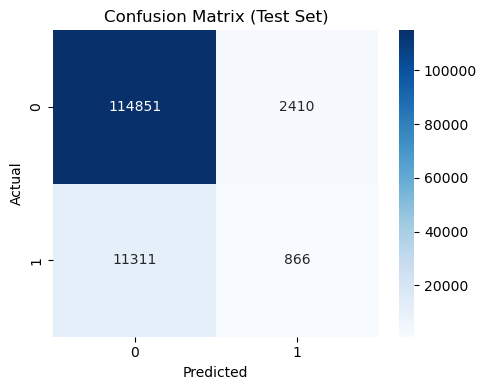

In [388]:
# RandomForest + SMOTETomek + Mean Imputation + 15 Interaction Features
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_curve
)
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek

# === Load & preprocess ===
df = pd.read_csv("Final_v3.csv")
df = pd.get_dummies(df, columns=['addr_state'])

# === Add 15 interaction features ===
df['int_rate_term'] = df['avg_interest_rate'] * df['term']
df['unemp_dti'] = df['unemployment_rate'] * df['dti']
df['inflation_install'] = df['implicit_regional_price_deflator'] * df['installment']
df['edu_inc'] = df['Population 25 years and over with Bachelor degree or higher'] * df['annual_inc']
df['poverty_term'] = df['Poverty Rate'] * df['term']
df['price_purpose'] = df['regional_price_parities_rpps_all_items'] * df['purpose']
df['uninsured_dti'] = df['Percent Uninsured'] * df['dti']
df['income_bal'] = df['state_real_per_capita_personal_income'] * df['revol_bal']
df['inq_gdp'] = df['inq_last_6mths'] * df['state_gdp_growth__summary_']
df['emp_growth'] = df['emp_length'] * df['state_total_employment_growth']

# 微观 * 微观

df['inq_dti'] = df['inq_last_6mths'] * df['dti']
df['install_util'] = df['installment'] * df['revol_util']
df['emp_inc'] = df['emp_length'] * df['annual_inc']
df['loan_bal'] = df['loan_amnt'] * df['revol_bal']
df['term_util'] = df['term'] * df['revol_util']


# ===  separate target ===
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# === Impute missing values ===
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# === Resample ===
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_imputed, y)

# === Initialize model & CV ===
rf1 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores, f1_scores, precision_scores, recall_scores = [], [], [], []
conf_matrix_sum = np.zeros((2, 2), dtype=int)
mean_fpr = np.linspace(0, 1, 100)
tprs = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_resampled, y_resampled), 1):
    X_train, X_val = X_resampled.iloc[train_idx], X_resampled.iloc[val_idx]
    y_train, y_val = y_resampled.iloc[train_idx], y_resampled.iloc[val_idx]

    rf1.fit(X_train, y_train)
    y_prob = rf1.predict_proba(X_val)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    auc = roc_auc_score(y_val, y_prob)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)

    auc_scores.append(auc)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    conf_matrix_sum += cm

    fpr, tpr, _ = roc_curve(y_val, y_prob)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

    print(f"\nFold {fold} | AUC: {auc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

print("\n===== Cross-Validation Metrics (5-Fold) =====")
print(f"Mean AUC       : {np.mean(auc_scores):.4f}")
print(f"Mean F1 Score  : {np.mean(f1_scores):.4f}")
print(f"Mean Precision : {np.mean(precision_scores):.4f}")
print(f"Mean Recall    : {np.mean(recall_scores):.4f}")

# === Confusion Matrix ===
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_sum, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Sum over 5-Fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === ROC Curve ===
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
plt.figure(figsize=(6, 5))
plt.plot(mean_fpr, mean_tpr, label=f"Mean ROC (AUC = {np.mean(auc_scores):.4f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curve (5-Fold CV)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Learning Curve ===
train_sizes, train_scores, val_scores = learning_curve(
    rf1, X_resampled, y_resampled, cv=5, scoring='roc_auc', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train AUC')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation AUC')
plt.xlabel("Training Samples")
plt.ylabel("AUC")
plt.title("Learning Curve (Random Forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Feature Importances ===
feature_names = X.columns
importances = rf1.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
# === Load & preprocess test set ===
test_df = pd.read_csv("Final_test_v3.csv")

# 保证列顺序和训练一致
test_df = pd.get_dummies(test_df, columns=['addr_state'])

# 构造 15 个交互变量
test_df['int_rate_term'] = test_df['avg_interest_rate'] * test_df['term']
test_df['unemp_dti'] = test_df['unemployment_rate'] * test_df['dti']
test_df['inflation_install'] = test_df['implicit_regional_price_deflator'] * test_df['installment']
test_df['edu_inc'] = test_df['Population 25 years and over with Bachelor degree or higher'] * test_df['annual_inc']
test_df['poverty_term'] = test_df['Poverty Rate'] * test_df['term']
test_df['price_purpose'] = test_df['regional_price_parities_rpps_all_items'] * test_df['purpose']
test_df['uninsured_dti'] = test_df['Percent Uninsured'] * test_df['dti']
test_df['income_bal'] = test_df['state_real_per_capita_personal_income'] * test_df['revol_bal']
test_df['inq_gdp'] = test_df['inq_last_6mths'] * test_df['state_gdp_growth__summary_']
test_df['emp_growth'] = test_df['emp_length'] * test_df['state_total_employment_growth']
test_df['inq_dti'] = test_df['inq_last_6mths'] * test_df['dti']
test_df['install_util'] = test_df['installment'] * test_df['revol_util']
test_df['emp_inc'] = test_df['emp_length'] * test_df['annual_inc']
test_df['loan_bal'] = test_df['loan_amnt'] * test_df['revol_bal']
test_df['term_util'] = test_df['term'] * test_df['revol_util']

# 标签分离
X_test = test_df.drop(columns=['loan_status'])
y_test = test_df['loan_status']

# 缺失值填充
X_test = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(X_test), columns=X_test.columns)

# 保证测试集列顺序与训练一致
X_test = X_test[rf1.feature_names_in_]

# 预测
y_prob = rf1.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

# 测试集评估指标
auc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("\n===== Test Set Performance =====")
print(f"AUC       : {auc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print("Confusion Matrix:\n", cm)

# 可视化 ROC 和混淆矩阵
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

Model saved to rf1_model_interaction.pkl
===== Top 20 Feature Importances =====
                 feature  importance  rank
0                  grade    0.087415     1
1   acc_open_past_24mths    0.058623     2
2        fico_range_high    0.039614     3
3         fico_range_low    0.038338     4
4         inq_last_6mths    0.037161     5
5            num_bc_sats    0.035391     6
6         home_ownership    0.034992     7
7             emp_length    0.027064     8
8             annual_inc    0.026288     9
9                    dti    0.023324    10
10             loan_amnt    0.022211    11
11             total_acc    0.021818    12
12           installment    0.021653    13
13               inq_dti    0.021356    14
14             term_util    0.020824    15
15             revol_bal    0.020760    16
16               emp_inc    0.020589    17
17            revol_util    0.020295    18
18              loan_bal    0.020271    19
19          install_util    0.019655    20


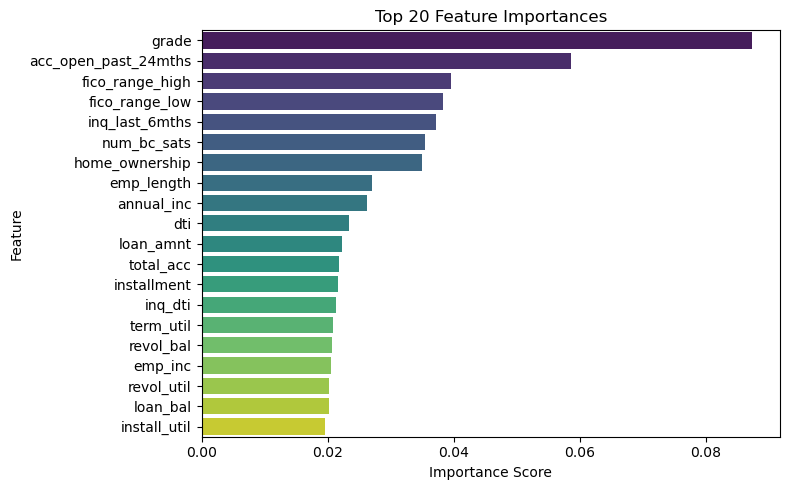

===== Macro Feature Importance Rankings =====
                                              feature  importance  rank
32                                  unemployment_rate    0.013111    33
33              state_real_per_capita_personal_income    0.012670    34
34             regional_price_parities_rpps_all_items    0.012651    35
35                                  Percent Uninsured    0.012634    36
36  Population 25 years and over with Bachelor deg...    0.012382    37
37  state_per_capital_personal_consumption_expendi...    0.012360    38
38                   implicit_regional_price_deflator    0.011970    39
39                                       Poverty Rate    0.011715    40
40                      state_total_employment_growth    0.011666    41
41                         state_gdp_growth__summary_    0.011637    42
45                                  avg_interest_rate    0.002073    46
===== Interaction Feature Importances & Rankings =====
              feature  importance  

In [332]:
import joblib

joblib.dump(rf1, "rf1_model_interaction.pkl")
print("Model saved to rf1_model_interaction.pkl")

importances = rf1.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

feat_df_sorted = feat_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
feat_df_sorted['rank'] = feat_df_sorted.index + 1

top20 = feat_df_sorted.head(20)
print("===== Top 20 Feature Importances =====")
print(top20)

plt.figure(figsize=(8, 5))
sns.barplot(x='importance', y='feature', data=top20, palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("top20_features_rf1.png")
plt.show()

macro_features = [
    'Population 25 years and over with Bachelor degree or higher',
    'Percent Uninsured',
    'Poverty Rate',
    'implicit_regional_price_deflator',
    'state_per_capital_personal_consumption_expenditurespce',
    'state_total_employment_growth',
    'regional_price_parities_rpps_all_items',
    'state_gdp_growth__summary_',
    'state_real_per_capita_personal_income',
    'avg_interest_rate',
    'unemployment_rate'
]

macro_df = feat_df_sorted[feat_df_sorted['feature'].isin(macro_features)]
print("===== Macro Feature Importance Rankings =====")
print(macro_df[['feature', 'importance', 'rank']])

interaction_features = [
    'int_rate_term', 'unemp_dti', 'inflation_install', 'edu_inc', 'poverty_term',
    'price_purpose', 'uninsured_dti', 'income_bal', 'inq_gdp', 'emp_growth',
    'inq_dti', 'install_util', 'emp_inc', 'loan_bal', 'term_util'
]

interaction_df = feat_df_sorted[feat_df_sorted['feature'].isin(interaction_features)]
print("===== Interaction Feature Importances & Rankings =====")
print(interaction_df[['feature', 'importance', 'rank']])


# 剔除宏观特征消融实验


Fold 1 | AUC: 0.9796 | F1: 0.9303 | Precision: 0.9774 | Recall: 0.8876

Fold 2 | AUC: 0.9797 | F1: 0.9303 | Precision: 0.9813 | Recall: 0.8843

Fold 3 | AUC: 0.9783 | F1: 0.9291 | Precision: 0.9791 | Recall: 0.8839

Fold 4 | AUC: 0.9799 | F1: 0.9295 | Precision: 0.9768 | Recall: 0.8866

Fold 5 | AUC: 0.9795 | F1: 0.9301 | Precision: 0.9796 | Recall: 0.8854

===== Cross-Validation Metrics (5-Fold) =====
Mean AUC       : 0.9794
Mean F1 Score  : 0.9299
Mean Precision : 0.9788
Mean Recall    : 0.8856


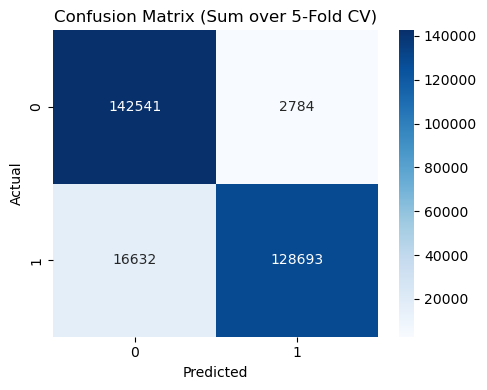

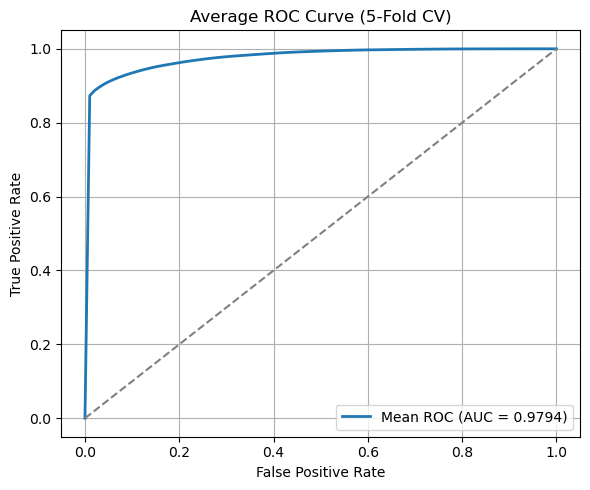

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 89,

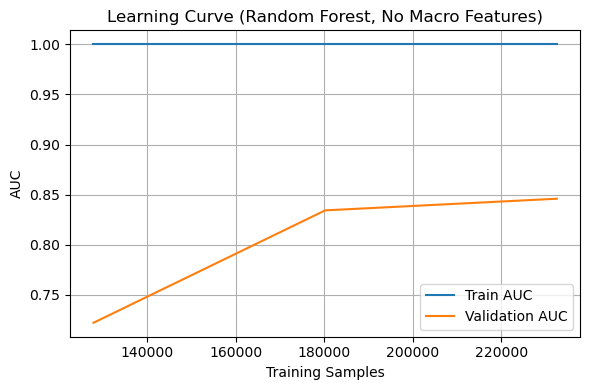

In [336]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_curve
)
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek

train_df = pd.read_csv("Final_v3.csv")
train_df = pd.get_dummies(train_df, columns=['addr_state'])

macro_features = [
    'Population 25 years and over with Bachelor degree or higher',
    'Percent Uninsured',
    'Poverty Rate',
    'implicit_regional_price_deflator',
    'state_per_capital_personal_consumption_expenditurespce',
    'state_total_employment_growth',
    'regional_price_parities_rpps_all_items',
    'state_gdp_growth__summary_',
    'state_real_per_capita_personal_income',
    'avg_interest_rate',
    'unemployment_rate'
]

X = train_df.drop(columns=['loan_status'] + macro_features)
y = train_df['loan_status']

imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_imputed, y)

rf2 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores, f1_scores, precision_scores, recall_scores = [], [], [], []
conf_matrix_sum = np.zeros((2, 2), dtype=int)
mean_fpr = np.linspace(0, 1, 100)
tprs = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_resampled, y_resampled), 1):
    X_train, X_val = X_resampled.iloc[train_idx], X_resampled.iloc[val_idx]
    y_train, y_val = y_resampled.iloc[train_idx], y_resampled.iloc[val_idx]

    rf2.fit(X_train, y_train)
    y_prob = rf2.predict_proba(X_val)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    auc_scores.append(roc_auc_score(y_val, y_prob))
    f1_scores.append(f1_score(y_val, y_pred))
    precision_scores.append(precision_score(y_val, y_pred))
    recall_scores.append(recall_score(y_val, y_pred))
    conf_matrix_sum += confusion_matrix(y_val, y_pred)

    fpr, tpr, _ = roc_curve(y_val, y_prob)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

    print(f"\nFold {fold} | AUC: {auc_scores[-1]:.4f} | F1: {f1_scores[-1]:.4f} | Precision: {precision_scores[-1]:.4f} | Recall: {recall_scores[-1]:.4f}")

print("\n===== Cross-Validation Metrics (5-Fold) =====")
print(f"Mean AUC       : {np.mean(auc_scores):.4f}")
print(f"Mean F1 Score  : {np.mean(f1_scores):.4f}")
print(f"Mean Precision : {np.mean(precision_scores):.4f}")
print(f"Mean Recall    : {np.mean(recall_scores):.4f}")

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_sum, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Sum over 5-Fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
plt.figure(figsize=(6, 5))
plt.plot(mean_fpr, mean_tpr, label=f"Mean ROC (AUC = {np.mean(auc_scores):.4f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curve (5-Fold CV)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

train_sizes, train_scores, val_scores = learning_curve(
    rf2, X_resampled, y_resampled, cv=5, scoring='roc_auc', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train AUC')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation AUC')
plt.xlabel("Training Samples")
plt.ylabel("AUC")
plt.title("Learning Curve (Random Forest, No Macro Features)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Model saved to rf2_model_only_micro.pkl
===== Top 20 Feature Importances =====
                           feature  importance  rank
0                            grade    0.079877     1
1             acc_open_past_24mths    0.076996     2
2                  fico_range_high    0.061198     3
3                   fico_range_low    0.057214     4
4                      num_bc_sats    0.050039     5
5                       annual_inc    0.048987     6
6                              dti    0.046079     7
7                        loan_amnt    0.043881     8
8                      installment    0.042917     9
9                        revol_bal    0.042818    10
10                      revol_util    0.042680    11
11                  inq_last_6mths    0.042097    12
12                      emp_length    0.041298    13
13                       total_acc    0.040901    14
14                      issue_year    0.033368    15
15                         purpose    0.025624    16
16  addr_state_-1.24

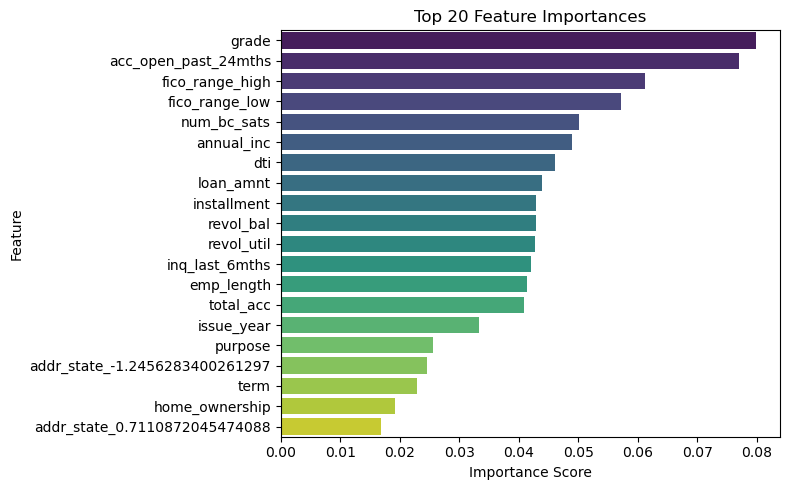

In [338]:
import joblib

joblib.dump(rf2, "rf2_model_only_micro.pkl")
print("Model saved to rf2_model_only_micro.pkl")

importances = rf2.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

feat_df_sorted = feat_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
feat_df_sorted['rank'] = feat_df_sorted.index + 1

top20 = feat_df_sorted.head(20)
print("===== Top 20 Feature Importances =====")
print(top20)

plt.figure(figsize=(8, 5))
sns.barplot(x='importance', y='feature', data=top20, palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("top20_features_rf2.png")
plt.show()


# 保留微观，剔除宏观，但保留交互特征


Fold 1 | AUC: 0.9821 | F1: 0.9351 | Precision: 0.9636 | Recall: 0.9083

Fold 2 | AUC: 0.9818 | F1: 0.9338 | Precision: 0.9636 | Recall: 0.9058

Fold 3 | AUC: 0.9827 | F1: 0.9352 | Precision: 0.9644 | Recall: 0.9077

Fold 4 | AUC: 0.9815 | F1: 0.9348 | Precision: 0.9631 | Recall: 0.9081

Fold 5 | AUC: 0.9827 | F1: 0.9348 | Precision: 0.9647 | Recall: 0.9067

===== Cross-Validation Metrics (5-Fold) =====
Mean AUC       : 0.9822
Mean F1 Score  : 0.9347
Mean Precision : 0.9639
Mean Recall    : 0.9073


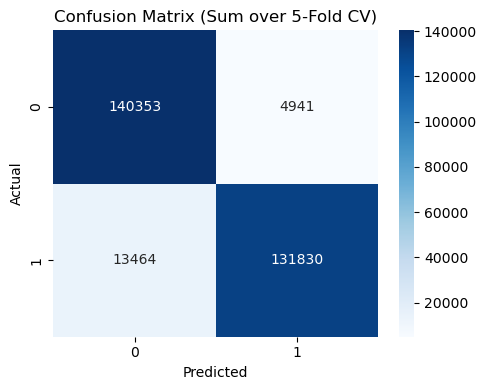

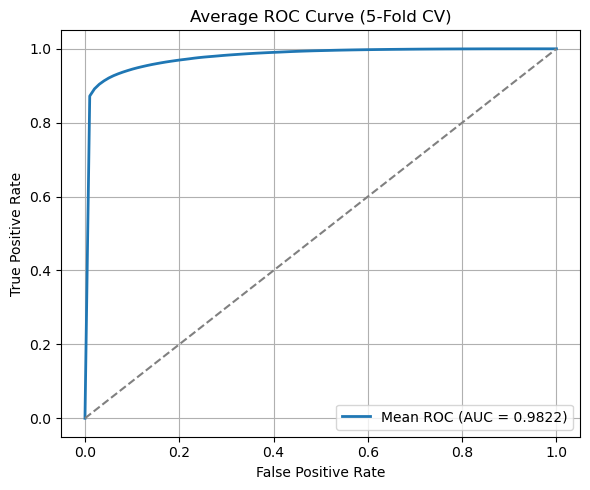

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 89,

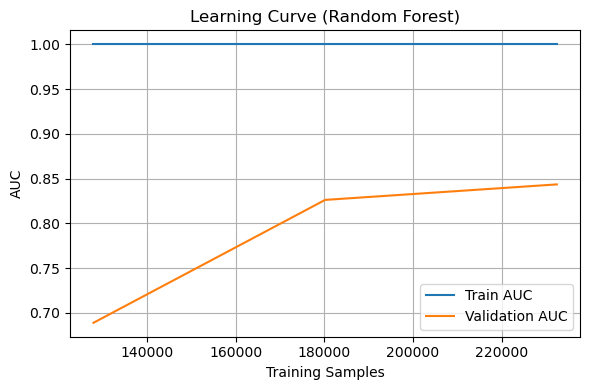

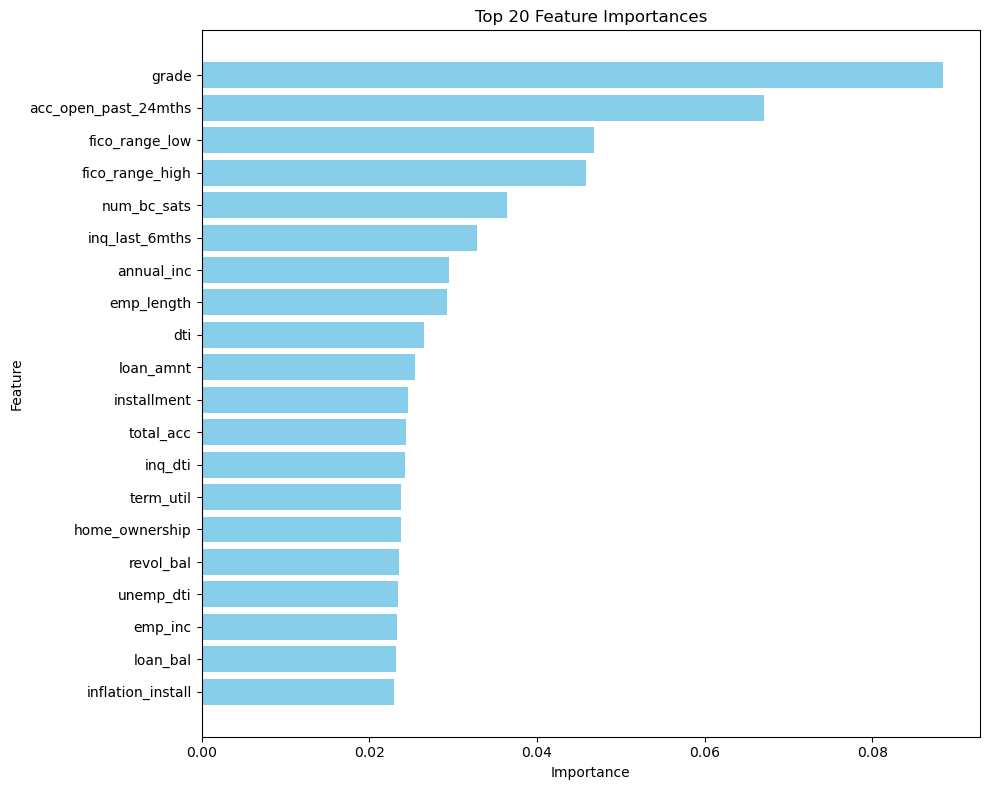

In [340]:
# RandomForest + SMOTETomek + Mean Imputation + 15 Interaction Features
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_curve
)
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek

# === Load & preprocess ===
df = pd.read_csv("Final_v3.csv")
df = pd.get_dummies(df, columns=['addr_state'])

# === Add 15 interaction features ===
df['int_rate_term'] = df['avg_interest_rate'] * df['term']
df['unemp_dti'] = df['unemployment_rate'] * df['dti']
df['inflation_install'] = df['implicit_regional_price_deflator'] * df['installment']
df['edu_inc'] = df['Population 25 years and over with Bachelor degree or higher'] * df['annual_inc']
df['poverty_term'] = df['Poverty Rate'] * df['term']
df['price_purpose'] = df['regional_price_parities_rpps_all_items'] * df['purpose']
df['uninsured_dti'] = df['Percent Uninsured'] * df['dti']
df['income_bal'] = df['state_real_per_capita_personal_income'] * df['revol_bal']
df['inq_gdp'] = df['inq_last_6mths'] * df['state_gdp_growth__summary_']
df['emp_growth'] = df['emp_length'] * df['state_total_employment_growth']

# 微观 * 微观

df['inq_dti'] = df['inq_last_6mths'] * df['dti']
df['install_util'] = df['installment'] * df['revol_util']
df['emp_inc'] = df['emp_length'] * df['annual_inc']
df['loan_bal'] = df['loan_amnt'] * df['revol_bal']
df['term_util'] = df['term'] * df['revol_util']

macro_features = [
    'Population 25 years and over with Bachelor degree or higher',
    'Percent Uninsured',
    'Poverty Rate',
    'implicit_regional_price_deflator',
    'state_per_capital_personal_consumption_expenditurespce',
    'state_total_employment_growth',
    'regional_price_parities_rpps_all_items',
    'state_gdp_growth__summary_',
    'state_real_per_capita_personal_income',
    'avg_interest_rate',
    'unemployment_rate'
]
# ===  separate target ===
X = df.drop(columns=['loan_status'] + macro_features)
y = df['loan_status']

# === Impute missing values ===
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# === Resample ===
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_imputed, y)

# === Initialize model & CV ===
rf3 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores, f1_scores, precision_scores, recall_scores = [], [], [], []
conf_matrix_sum = np.zeros((2, 2), dtype=int)
mean_fpr = np.linspace(0, 1, 100)
tprs = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_resampled, y_resampled), 1):
    X_train, X_val = X_resampled.iloc[train_idx], X_resampled.iloc[val_idx]
    y_train, y_val = y_resampled.iloc[train_idx], y_resampled.iloc[val_idx]

    rf3.fit(X_train, y_train)
    y_prob = rf3.predict_proba(X_val)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    auc = roc_auc_score(y_val, y_prob)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)

    auc_scores.append(auc)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    conf_matrix_sum += cm

    fpr, tpr, _ = roc_curve(y_val, y_prob)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

    print(f"\nFold {fold} | AUC: {auc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

print("\n===== Cross-Validation Metrics (5-Fold) =====")
print(f"Mean AUC       : {np.mean(auc_scores):.4f}")
print(f"Mean F1 Score  : {np.mean(f1_scores):.4f}")
print(f"Mean Precision : {np.mean(precision_scores):.4f}")
print(f"Mean Recall    : {np.mean(recall_scores):.4f}")

# === Confusion Matrix ===
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_sum, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Sum over 5-Fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === ROC Curve ===
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
plt.figure(figsize=(6, 5))
plt.plot(mean_fpr, mean_tpr, label=f"Mean ROC (AUC = {np.mean(auc_scores):.4f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curve (5-Fold CV)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Learning Curve ===
train_sizes, train_scores, val_scores = learning_curve(
    rf3, X_resampled, y_resampled, cv=5, scoring='roc_auc', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train AUC')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation AUC')
plt.xlabel("Training Samples")
plt.ylabel("AUC")
plt.title("Learning Curve (Random Forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Feature Importances ===
feature_names = X.columns
importances = rf3.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Model saved to rf1_model_micro_and_interaction.pkl
===== Top 20 Feature Importances =====
                 feature  importance  rank
0                  grade    0.088439     1
1   acc_open_past_24mths    0.067097     2
2         fico_range_low    0.046845     3
3        fico_range_high    0.045859     4
4            num_bc_sats    0.036444     5
5         inq_last_6mths    0.032850     6
6             annual_inc    0.029503     7
7             emp_length    0.029292     8
8                    dti    0.026553     9
9              loan_amnt    0.025471    10
10           installment    0.024577    11
11             total_acc    0.024378    12
12               inq_dti    0.024315    13
13             term_util    0.023792    14
14        home_ownership    0.023763    15
15             revol_bal    0.023516    16
16             unemp_dti    0.023414    17
17               emp_inc    0.023342    18
18              loan_bal    0.023156    19
19     inflation_install    0.023009    20


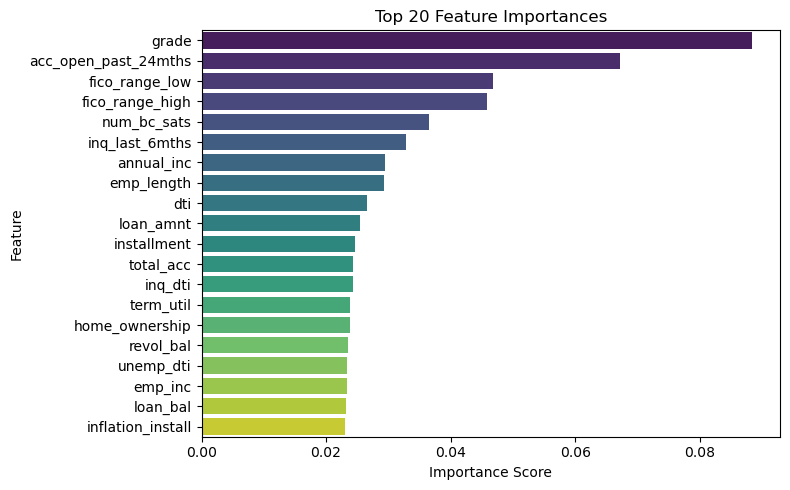

===== Interaction Feature Importances & Rankings =====
              feature  importance  rank
12            inq_dti    0.024315    13
13          term_util    0.023792    14
16          unemp_dti    0.023414    17
17            emp_inc    0.023342    18
18           loan_bal    0.023156    19
19  inflation_install    0.023009    20
20      uninsured_dti    0.022922    21
22       install_util    0.022630    23
23         income_bal    0.022597    24
24            edu_inc    0.022471    25
25         emp_growth    0.022065    26
26      price_purpose    0.021998    27
27            inq_gdp    0.020975    28
28       poverty_term    0.020480    29
32      int_rate_term    0.007682    33


In [341]:
import joblib

joblib.dump(rf3, "rf3_model_micro_and_interaction.pkl")
print("Model saved to rf1_model_micro_and_interaction.pkl")

importances = rf3.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

feat_df_sorted = feat_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
feat_df_sorted['rank'] = feat_df_sorted.index + 1

top20 = feat_df_sorted.head(20)
print("===== Top 20 Feature Importances =====")
print(top20)

plt.figure(figsize=(8, 5))
sns.barplot(x='importance', y='feature', data=top20, palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("top20_features_rf3.png")
plt.show()

macro_features = [
    'Population 25 years and over with Bachelor degree or higher',
    'Percent Uninsured',
    'Poverty Rate',
    'implicit_regional_price_deflator',
    'state_per_capital_personal_consumption_expenditurespce',
    'state_total_employment_growth',
    'regional_price_parities_rpps_all_items',
    'state_gdp_growth__summary_',
    'state_real_per_capita_personal_income',
    'avg_interest_rate',
    'unemployment_rate'
]

macro_df = feat_df_sorted[feat_df_sorted['feature'].isin(macro_features)]
print("===== Macro Feature Importance Rankings =====")
print(macro_df[['feature', 'importance', 'rank']])

interaction_features = [
    'int_rate_term', 'unemp_dti', 'inflation_install', 'edu_inc', 'poverty_term',
    'price_purpose', 'uninsured_dti', 'income_bal', 'inq_gdp', 'emp_growth',
    'inq_dti', 'install_util', 'emp_inc', 'loan_bal', 'term_util'
]

interaction_df = feat_df_sorted[feat_df_sorted['feature'].isin(interaction_features)]
print("===== Interaction Feature Importances & Rankings =====")
print(interaction_df[['feature', 'importance', 'rank']])